## Imports

In [85]:
pip install catboost

In [86]:
pip install pyupset

In [87]:
!pip install upsetplot

In [88]:
import gc
import os
import itertools
import pickle
import re
import time

import warnings
warnings.filterwarnings('ignore')

from random import choice, choices
from functools import reduce
from tqdm import tqdm
from itertools import cycle

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
from upsetplot import UpSet
%matplotlib inline

from functools import reduce
from tqdm import tqdm
from itertools import cycle
from scipy import stats
from sklearn import metrics
from sklearn import model_selection
from sklearn import preprocessing
from sklearn import linear_model
from sklearn import ensemble
from sklearn import decomposition
from sklearn import tree

import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor, Pool

pd.set_option("display.max_columns", None)

plt.style.use("ggplot")
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
color_cycle = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])

## Data Loading

In [89]:
pcp_df = pd.read_csv("/content/imgs_202307101549519358.csv")
cl_df = pd.read_csv("/content/imgs_2023071012130978799.csv")
bs_df = pd.read_csv("/content/imgs_2023071012123392536.csv")
ec_df  = pd.read_csv("/content/imgs_2023071012133740345.csv")
ss_df = pd.read_csv("/content/SampleSubmission (2).csv")

pcp_df.shape, cl_df.shape, bs_df.shape, ec_df.shape, ss_df.shape

((26139, 4), (125575, 10), (1217, 8), (92629, 3), (26139, 2))

In [90]:
ec_df.head()

Time   BS     Energy
0  1/1/2023 1:00  B_0  64.275037
1  1/1/2023 2:00  B_0  55.904335
2  1/1/2023 3:00  B_0  57.698057
3  1/1/2023 4:00  B_0  55.156951
4  1/1/2023 5:00  B_0  56.053812

In [91]:
cl_df.head()

Time   BS CellName      load  ESMode1  ESMode2  ESMode3  ESMode4  \
0  1/1/2023 1:00  B_0    Cell0  0.487936      0.0      0.0      0.0        0   
1  1/1/2023 2:00  B_0    Cell0  0.344468      0.0      0.0      0.0        0   
2  1/1/2023 3:00  B_0    Cell0  0.193766      0.0      0.0      0.0        0   
3  1/1/2023 4:00  B_0    Cell0  0.222383      0.0      0.0      0.0        0   
4  1/1/2023 5:00  B_0    Cell0  0.175436      0.0      0.0      0.0        0   

   ESMode5  ESMode6  
0      0.0      0.0  
1      0.0      0.0  
2      0.0      0.0  
3      0.0      0.0  
4      0.0      0.0

In [92]:
bs_df.head()

BS CellName RUType   Mode  Frequency  Bandwidth  Antennas   TXpower
0  B_0    Cell0  Type1  Mode2      365.0         20         4  6.875934
1  B_1    Cell0  Type2  Mode2      532.0         20         4  6.875934
2  B_2    Cell0  Type1  Mode2      365.0         20         4  6.875934
3  B_3    Cell0  Type2  Mode2      532.0         20         4  6.875934
4  B_4    Cell0  Type2  Mode2      532.0         20         4  6.875934

In [93]:
pcp_df.head()

Time   BS  Energy  w
0  2023-01-01 06:00:00  B_0     NaN  1
1  2023-01-01 11:00:00  B_0     NaN  1
2  2023-01-01 12:00:00  B_0     NaN  1
3  2023-01-01 13:00:00  B_0     NaN  1
4  2023-01-01 23:00:00  B_0     NaN  1

In [94]:
pcp_df['w'].value_counts()

1    23189
5     2950
Name: w, dtype: int64

## Data Pre-Processing

In [95]:
def rename_columns(df):
    df.rename(columns=lambda x: x.lower().replace(' ', '_'), inplace=True)
    return df

In [96]:
pcp_df = rename_columns(pcp_df)
cl_df = rename_columns(cl_df)
bs_df = rename_columns(bs_df)
ec_df = rename_columns(ec_df)

In [97]:
cl_df.head()

time   bs cellname      load  esmode1  esmode2  esmode3  esmode4  \
0  1/1/2023 1:00  B_0    Cell0  0.487936      0.0      0.0      0.0        0   
1  1/1/2023 2:00  B_0    Cell0  0.344468      0.0      0.0      0.0        0   
2  1/1/2023 3:00  B_0    Cell0  0.193766      0.0      0.0      0.0        0   
3  1/1/2023 4:00  B_0    Cell0  0.222383      0.0      0.0      0.0        0   
4  1/1/2023 5:00  B_0    Cell0  0.175436      0.0      0.0      0.0        0   

   esmode5  esmode6  
0      0.0      0.0  
1      0.0      0.0  
2      0.0      0.0  
3      0.0      0.0  
4      0.0      0.0

In [98]:
bs_df.head()

bs cellname rutype   mode  frequency  bandwidth  antennas   txpower
0  B_0    Cell0  Type1  Mode2      365.0         20         4  6.875934
1  B_1    Cell0  Type2  Mode2      532.0         20         4  6.875934
2  B_2    Cell0  Type1  Mode2      365.0         20         4  6.875934
3  B_3    Cell0  Type2  Mode2      532.0         20         4  6.875934
4  B_4    Cell0  Type2  Mode2      532.0         20         4  6.875934

In [99]:
ec_df.head()

time   bs     energy
0  1/1/2023 1:00  B_0  64.275037
1  1/1/2023 2:00  B_0  55.904335
2  1/1/2023 3:00  B_0  57.698057
3  1/1/2023 4:00  B_0  55.156951
4  1/1/2023 5:00  B_0  56.053812

In [100]:
pcp_df.head()

time   bs  energy  w
0  2023-01-01 06:00:00  B_0     NaN  1
1  2023-01-01 11:00:00  B_0     NaN  1
2  2023-01-01 12:00:00  B_0     NaN  1
3  2023-01-01 13:00:00  B_0     NaN  1
4  2023-01-01 23:00:00  B_0     NaN  1

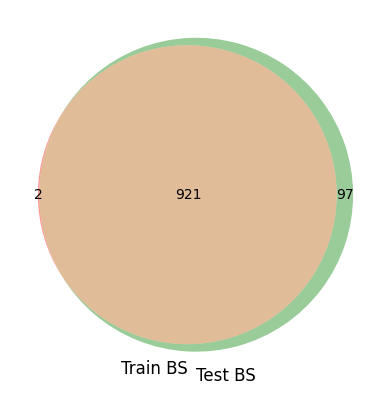

In [102]:
train_bs_set = set(ec_df['bs'].values.tolist())
test_bs_set = set(pcp_df['bs'].values.tolist())

venn2([train_bs_set, test_bs_set], ('Train BS', 'Test BS'))
plt.show()

In [104]:
cl_df['time'] = pd.to_datetime(cl_df['time'])
ec_df['time'] = pd.to_datetime(ec_df['time'])
pcp_df['time'] = pd.to_datetime(pcp_df['time'])

In [105]:
data = {
    'Train BS': train_bs_set,
    'Test BS': test_bs_set
}


In [106]:
cl_bs_df = cl_df.merge(bs_df, on=['bs', 'cellname'], how='left')
cl_bs_df.head()

time   bs cellname      load  esmode1  esmode2  esmode3  \
0 2023-01-01 01:00:00  B_0    Cell0  0.487936      0.0      0.0      0.0   
1 2023-01-01 02:00:00  B_0    Cell0  0.344468      0.0      0.0      0.0   
2 2023-01-01 03:00:00  B_0    Cell0  0.193766      0.0      0.0      0.0   
3 2023-01-01 04:00:00  B_0    Cell0  0.222383      0.0      0.0      0.0   
4 2023-01-01 05:00:00  B_0    Cell0  0.175436      0.0      0.0      0.0   

   esmode4  esmode5  esmode6 rutype   mode  frequency  bandwidth  antennas  \
0        0      0.0      0.0  Type1  Mode2      365.0         20         4   
1        0      0.0      0.0  Type1  Mode2      365.0         20         4   
2        0      0.0      0.0  Type1  Mode2      365.0         20         4   
3        0      0.0      0.0  Type1  Mode2      365.0         20         4   
4        0      0.0      0.0  Type1  Mode2      365.0         20         4   

    txpower  
0  6.875934  
1  6.875934  
2  6.875934  
3  6.875934  
4  6.875934

In [107]:
cl_bs_df[cl_bs_df['bs'] == 'B_0']

time   bs cellname      load  esmode1  esmode2  esmode3  \
0      2023-01-01 01:00:00  B_0    Cell0  0.487936      0.0      0.0      0.0   
1      2023-01-01 02:00:00  B_0    Cell0  0.344468      0.0      0.0      0.0   
2      2023-01-01 03:00:00  B_0    Cell0  0.193766      0.0      0.0      0.0   
3      2023-01-01 04:00:00  B_0    Cell0  0.222383      0.0      0.0      0.0   
4      2023-01-01 05:00:00  B_0    Cell0  0.175436      0.0      0.0      0.0   
...                    ...  ...      ...       ...      ...      ...      ...   
118787 2023-01-02 19:00:00  B_0    Cell1  0.206135      0.0      0.0      0.0   
118788 2023-01-02 20:00:00  B_0    Cell1  0.152981      0.0      0.0      0.0   
118789 2023-01-02 21:00:00  B_0    Cell1  0.150808      0.0      0.0      0.0   
118790 2023-01-02 22:00:00  B_0    Cell1  0.289731      0.0      0.0      0.0   
118791 2023-01-02 23:00:00  B_0    Cell1  0.200519      0.0      0.0      0.0   

        esmode4  esmode5  esmode6 rutype   mode  frequency  bandwidth  \
0             0      0.0      0.0  Type1  Mode2     365.00         20   
1             0      0.0      0.0  Type1  Mode2     365.00         20   
2             0      0.0      0.0  Type1  Mode2     365.00         20   
3             0      0.0      0.0  Type1  Mode2     365.00         20   
4             0      0.0      0.0  Type1  Mode2     365.00         20   
...         ...      ...      ...    ...    ...        ...        ...   
118787        0      0.0      0.0  Type1  Mode2     426.98          2   
118788        0      0.0      0.0  Type1  Mode2     426.98          2   
118789        0      0.0      0.0  Type1  Mode2     426.98          2   
118790        0      0.0      0.0  Type1  Mode2     426.98          2   
118791        0      0.0      0.0  Type1  Mode2     426.98          2   

        antennas   txpower  
0              4  6.875934  
1              4  6.875934  
2              4  6.875934  
3              4  6.875934  
4              4  6.875934  
...          ...       ...  
118787         4  7.327504  
118788         4  7.327504  
118789         4  7.327504  
118790         4  7.327504  
118791         4  7.327504  

[156 rows x 16 columns]

In [108]:
cl_bs_df.groupby("bs")['cellname'].nunique()

bs
B_0       2
B_1       1
B_10      2
B_100     1
B_1000    1
         ..
B_995     1
B_996     1
B_997     1
B_998     1
B_999     1
Name: cellname, Length: 1020, dtype: int64

In [109]:
cl_bs_df.groupby("bs")['cellname'].nunique().value_counts()

1    827
2    191
4      2
Name: cellname, dtype: int64

In [110]:
ec_df.head()

time   bs     energy
0 2023-01-01 01:00:00  B_0  64.275037
1 2023-01-01 02:00:00  B_0  55.904335
2 2023-01-01 03:00:00  B_0  57.698057
3 2023-01-01 04:00:00  B_0  55.156951
4 2023-01-01 05:00:00  B_0  56.053812

In [111]:
cl_bs_df.head()

time   bs cellname      load  esmode1  esmode2  esmode3  \
0 2023-01-01 01:00:00  B_0    Cell0  0.487936      0.0      0.0      0.0   
1 2023-01-01 02:00:00  B_0    Cell0  0.344468      0.0      0.0      0.0   
2 2023-01-01 03:00:00  B_0    Cell0  0.193766      0.0      0.0      0.0   
3 2023-01-01 04:00:00  B_0    Cell0  0.222383      0.0      0.0      0.0   
4 2023-01-01 05:00:00  B_0    Cell0  0.175436      0.0      0.0      0.0   

   esmode4  esmode5  esmode6 rutype   mode  frequency  bandwidth  antennas  \
0        0      0.0      0.0  Type1  Mode2      365.0         20         4   
1        0      0.0      0.0  Type1  Mode2      365.0         20         4   
2        0      0.0      0.0  Type1  Mode2      365.0         20         4   
3        0      0.0      0.0  Type1  Mode2      365.0         20         4   
4        0      0.0      0.0  Type1  Mode2      365.0         20         4   

    txpower  
0  6.875934  
1  6.875934  
2  6.875934  
3  6.875934  
4  6.875934

In [112]:
cl_bs_df = cl_bs_df.pivot(
    index=['time', 'bs'],
    columns=['cellname'],
    values=['load', 'esmode1', 'esmode2', 'esmode3',
       'esmode4', 'esmode5', 'esmode6', 'frequency',
       'bandwidth', 'antennas', 'txpower'],
).reset_index()

cl_bs_df.columns = ['_'.join([str(i) for i in x]) for x in cl_bs_df.columns]
cl_bs_df.columns = cl_bs_df.columns.str.strip('_')
cl_bs_df = rename_columns(cl_bs_df)
cl_bs_df = cl_bs_df.merge(bs_df.groupby('bs')[['rutype', 'mode']].first().reset_index(), on='bs', how='left')

In [113]:
cl_bs_df.head()

time     bs  load_cell0  load_cell1  load_cell2  load_cell3  \
0 2023-01-01 01:00:00    B_0    0.487936         NaN         NaN         NaN   
1 2023-01-01 01:00:00    B_1    0.034770         NaN         NaN         NaN   
2 2023-01-01 01:00:00   B_10    0.010457         NaN         NaN         NaN   
3 2023-01-01 01:00:00  B_100    0.011220         NaN         NaN         NaN   
4 2023-01-01 01:00:00  B_101    0.008720         NaN         NaN         NaN   

   esmode1_cell0  esmode1_cell1  esmode1_cell2  esmode1_cell3  esmode2_cell0  \
0            0.0            NaN            NaN            NaN            0.0   
1            0.0            NaN            NaN            NaN            0.0   
2            0.0            NaN            NaN            NaN            0.0   
3            0.0            NaN            NaN            NaN            0.0   
4            0.0            NaN            NaN            NaN            0.0   

   esmode2_cell1  esmode2_cell2  esmode2_cell3  esmode3_cell0  esmode3_cell1  \
0            NaN            NaN            NaN            0.0            NaN   
1            NaN            NaN            NaN            0.0            NaN   
2            NaN            NaN            NaN            0.0            NaN   
3            NaN            NaN            NaN            0.0            NaN   
4            NaN            NaN            NaN            0.0            NaN   

   esmode3_cell2  esmode3_cell3  esmode4_cell0  esmode4_cell1  esmode4_cell2  \
0            NaN            NaN            0.0            NaN            NaN   
1            NaN            NaN            0.0            NaN            NaN   
2            NaN            NaN            0.0            NaN            NaN   
3            NaN            NaN            0.0            NaN            NaN   
4            NaN            NaN            0.0            NaN            NaN   

   esmode4_cell3  esmode5_cell0  esmode5_cell1  esmode5_cell2  esmode5_cell3  \
0            NaN            0.0            NaN            NaN            NaN   
1            NaN            0.0            NaN            NaN            NaN   
2            NaN            0.0            NaN            NaN            NaN   
3            NaN            0.0            NaN            NaN            NaN   
4            NaN            0.0            NaN            NaN            NaN   

   esmode6_cell0  esmode6_cell1  esmode6_cell2  esmode6_cell3  \
0            0.0            NaN            NaN            NaN   
1            0.0            NaN            NaN            NaN   
2            0.0            NaN            NaN            NaN   
3            0.0            NaN            NaN            NaN   
4            0.0            NaN            NaN            NaN   

   frequency_cell0  frequency_cell1  frequency_cell2  frequency_cell3  \
0            365.0              NaN              NaN              NaN   
1            532.0              NaN              NaN              NaN   
2            365.0              NaN              NaN              NaN   
3            532.0              NaN              NaN              NaN   
4            532.0              NaN              NaN              NaN   

   bandwidth_cell0  bandwidth_cell1  bandwidth_cell2  bandwidth_cell3  \
0             20.0              NaN              NaN              NaN   
1             20.0              NaN              NaN              NaN   
2             20.0              NaN              NaN              NaN   
3             20.0              NaN              NaN              NaN   
4             20.0              NaN              NaN              NaN   

   antennas_cell0  antennas_cell1  antennas_cell2  antennas_cell3  \
0             4.0             NaN             NaN             NaN   
1             4.0             NaN             NaN             NaN   
2             2.0             NaN             NaN             NaN   
3             2.0             NaN             NaN             NaN  

In [114]:
cl_bs_df.describe()

load_cell0   load_cell1  load_cell2  load_cell3  esmode1_cell0  \
count  118768.000000  6711.000000   48.000000   48.000000  118768.000000   
mean        0.246362     0.111214    0.070212    0.081115       0.042145   
std         0.239354     0.091569    0.023807    0.038373       0.194184   
min         0.000000     0.008190    0.045942    0.045904       0.000000   
25%         0.055714     0.051894    0.054442    0.051822       0.000000   
50%         0.162470     0.079423    0.066760    0.067856       0.000000   
75%         0.367142     0.138202    0.079385    0.095495       0.000000   
max         0.993957     0.891770    0.174846    0.196519       1.000000   

       esmode1_cell1  esmode1_cell2  esmode1_cell3  esmode2_cell0  \
count    6711.000000           48.0           48.0  118768.000000   
mean        0.004985            0.0            0.0       0.038640   
std         0.064911            0.0            0.0       0.186785   
min         0.000000            0.0            0.0       0.000000   
25%         0.000000            0.0            0.0       0.000000   
50%         0.000000            0.0            0.0       0.000000   
75%         0.000000            0.0            0.0       0.000000   
max         1.000000            0.0            0.0       1.000000   

       esmode2_cell1  esmode2_cell2  esmode2_cell3  esmode3_cell0  \
count    6711.000000           48.0           48.0  118768.000000   
mean        0.003311            0.0            0.0       0.000082   
std         0.052831            0.0            0.0       0.002439   
min         0.000000            0.0            0.0       0.000000   
25%         0.000000            0.0            0.0       0.000000   
50%         0.000000            0.0            0.0       0.000000   
75%         0.000000            0.0            0.0       0.000000   
max         1.000000            0.0            0.0       0.154563   

       esmode3_cell1  esmode3_cell2  esmode3_cell3  esmode4_cell0  \
count    6711.000000           48.0           48.0       118768.0   
mean        0.000135            0.0            0.0            0.0   
std         0.002422            0.0            0.0            0.0   
min         0.000000            0.0            0.0            0.0   
25%         0.000000            0.0            0.0            0.0   
50%         0.000000            0.0            0.0            0.0   
75%         0.000000            0.0            0.0            0.0   
max         0.062805            0.0            0.0            0.0   

       esmode4_cell1  esmode4_cell2  esmode4_cell3  esmode5_cell0  \
count         6711.0           48.0           48.0  118768.000000   
mean             0.0            0.0            0.0       0.000012   
std              0.0            0.0            0.0       0.002882   
min              0.0            0.0            0.0       0.000000   
25%              0.0            0.0            0.0       0.000000   
50%              0.0            0.0            0.0       0.000000   
75%              0.0            0.0            0.0       0.000000   
max              0.0            0.0            0.0       0.768070   

       esmode5_cell1  esmode5_cell2  esmode5_cell3  esmode6_cell0  \
count         6711.0           48.0           48.0  118768.000000   
mean             0.0            0.0            0.0       0.019168   
std              0.0            0.0            0.0       0.112214   
min              0.0            0.0            0.0       0.000000   
25%              0.0            0.0            0.0       0.000000   
50%              0.0            0.0            0.0       0.000000   
75%              0.0            0.0            0.0       0.000000   
max              0.0            0.0            0.0       0.931032   

       esmode6_cell1  esmode6_cell2  esmode6_cell3  frequency_cell0  \
count    6711.000000           48.0           48.0    118768.000000   
mean        0.386253            0.0            0.0       373.152776   
st

In [115]:
ec_df.head()

time   bs     energy
0 2023-01-01 01:00:00  B_0  64.275037
1 2023-01-01 02:00:00  B_0  55.904335
2 2023-01-01 03:00:00  B_0  57.698057
3 2023-01-01 04:00:00  B_0  55.156951
4 2023-01-01 05:00:00  B_0  56.053812

In [116]:
df = cl_bs_df.merge(ec_df, on=['time', 'bs'], how='left')

In [117]:
df.head()

time     bs  load_cell0  load_cell1  load_cell2  load_cell3  \
0 2023-01-01 01:00:00    B_0    0.487936         NaN         NaN         NaN   
1 2023-01-01 01:00:00    B_1    0.034770         NaN         NaN         NaN   
2 2023-01-01 01:00:00   B_10    0.010457         NaN         NaN         NaN   
3 2023-01-01 01:00:00  B_100    0.011220         NaN         NaN         NaN   
4 2023-01-01 01:00:00  B_101    0.008720         NaN         NaN         NaN   

   esmode1_cell0  esmode1_cell1  esmode1_cell2  esmode1_cell3  esmode2_cell0  \
0            0.0            NaN            NaN            NaN            0.0   
1            0.0            NaN            NaN            NaN            0.0   
2            0.0            NaN            NaN            NaN            0.0   
3            0.0            NaN            NaN            NaN            0.0   
4            0.0            NaN            NaN            NaN            0.0   

   esmode2_cell1  esmode2_cell2  esmode2_cell3  esmode3_cell0  esmode3_cell1  \
0            NaN            NaN            NaN            0.0            NaN   
1            NaN            NaN            NaN            0.0            NaN   
2            NaN            NaN            NaN            0.0            NaN   
3            NaN            NaN            NaN            0.0            NaN   
4            NaN            NaN            NaN            0.0            NaN   

   esmode3_cell2  esmode3_cell3  esmode4_cell0  esmode4_cell1  esmode4_cell2  \
0            NaN            NaN            0.0            NaN            NaN   
1            NaN            NaN            0.0            NaN            NaN   
2            NaN            NaN            0.0            NaN            NaN   
3            NaN            NaN            0.0            NaN            NaN   
4            NaN            NaN            0.0            NaN            NaN   

   esmode4_cell3  esmode5_cell0  esmode5_cell1  esmode5_cell2  esmode5_cell3  \
0            NaN            0.0            NaN            NaN            NaN   
1            NaN            0.0            NaN            NaN            NaN   
2            NaN            0.0            NaN            NaN            NaN   
3            NaN            0.0            NaN            NaN            NaN   
4            NaN            0.0            NaN            NaN            NaN   

   esmode6_cell0  esmode6_cell1  esmode6_cell2  esmode6_cell3  \
0            0.0            NaN            NaN            NaN   
1            0.0            NaN            NaN            NaN   
2            0.0            NaN            NaN            NaN   
3            0.0            NaN            NaN            NaN   
4            0.0            NaN            NaN            NaN   

   frequency_cell0  frequency_cell1  frequency_cell2  frequency_cell3  \
0            365.0              NaN              NaN              NaN   
1            532.0              NaN              NaN              NaN   
2            365.0              NaN              NaN              NaN   
3            532.0              NaN              NaN              NaN   
4            532.0              NaN              NaN              NaN   

   bandwidth_cell0  bandwidth_cell1  bandwidth_cell2  bandwidth_cell3  \
0             20.0              NaN              NaN              NaN   
1             20.0              NaN              NaN              NaN   
2             20.0              NaN              NaN              NaN   
3             20.0              NaN              NaN              NaN   
4             20.0              NaN              NaN              NaN   

   antennas_cell0  antennas_cell1  antennas_cell2  antennas_cell3  \
0             4.0             NaN             NaN             NaN   
1             4.0             NaN             NaN             NaN   
2             2.0             NaN             NaN             NaN   
3             2.0             NaN             NaN             NaN  

In [118]:
df['energy'].isna().value_counts()

False    92629
True     26139
Name: energy, dtype: int64

In [119]:
df['split'] = df['energy'].isna().apply(lambda x: 'test' if x == True else 'train')

In [120]:
ss_df.shape

(26139, 2)

In [121]:
ec_df.shape

(92629, 3)

## EDA

In [122]:
df['energy'].describe()

count    92629.000000
mean        28.138997
std         13.934645
min          0.747384
25%         18.236173
50%         24.065770
75%         35.724963
max        100.000000
Name: energy, dtype: float64

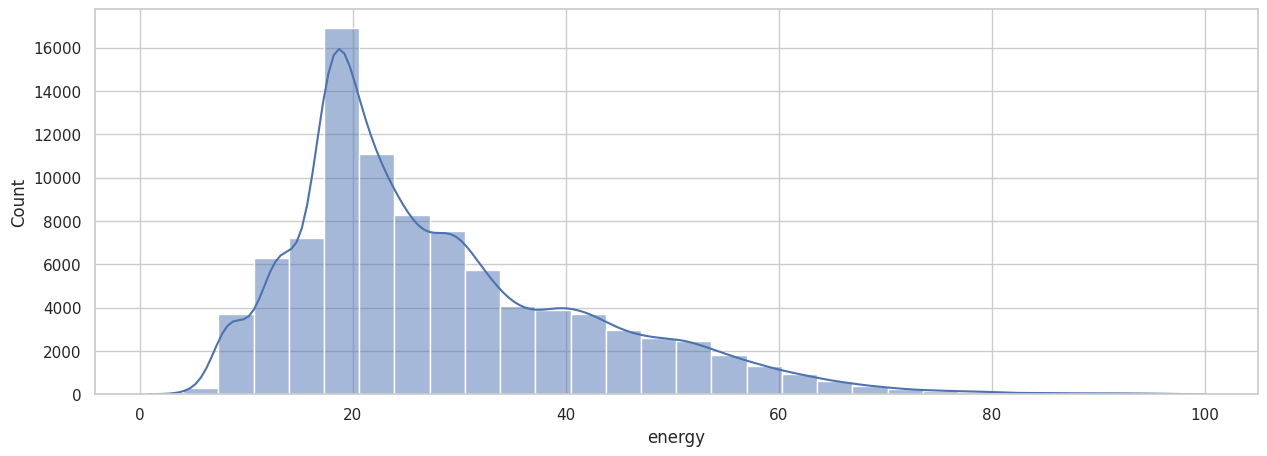

In [123]:

sns.set(style="whitegrid")
plt.figure(figsize=(15, 5))
sns.histplot(df['energy'], bins=30, kde=True)
plt.show()

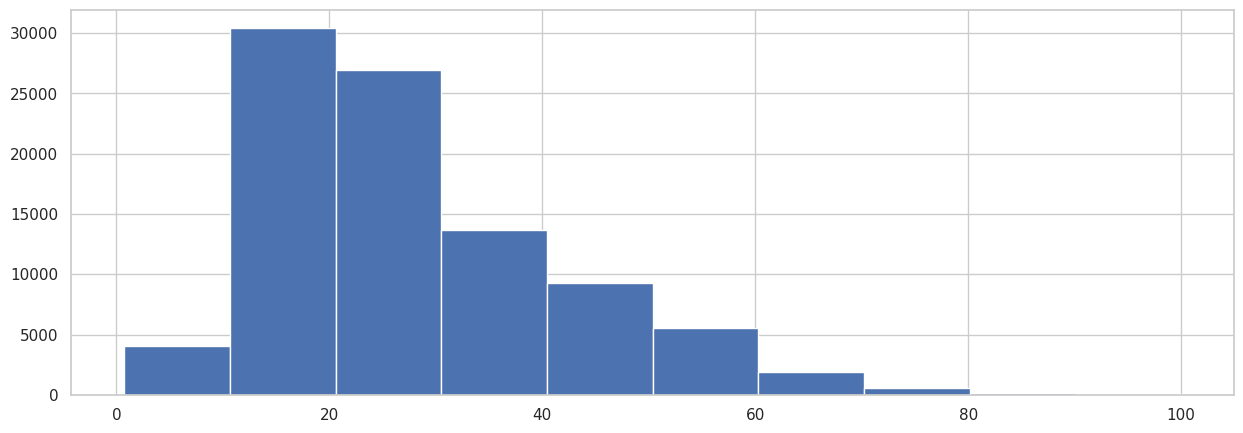

In [124]:
plt.figure(figsize=(15, 5))
df['energy'].hist()
plt.show()

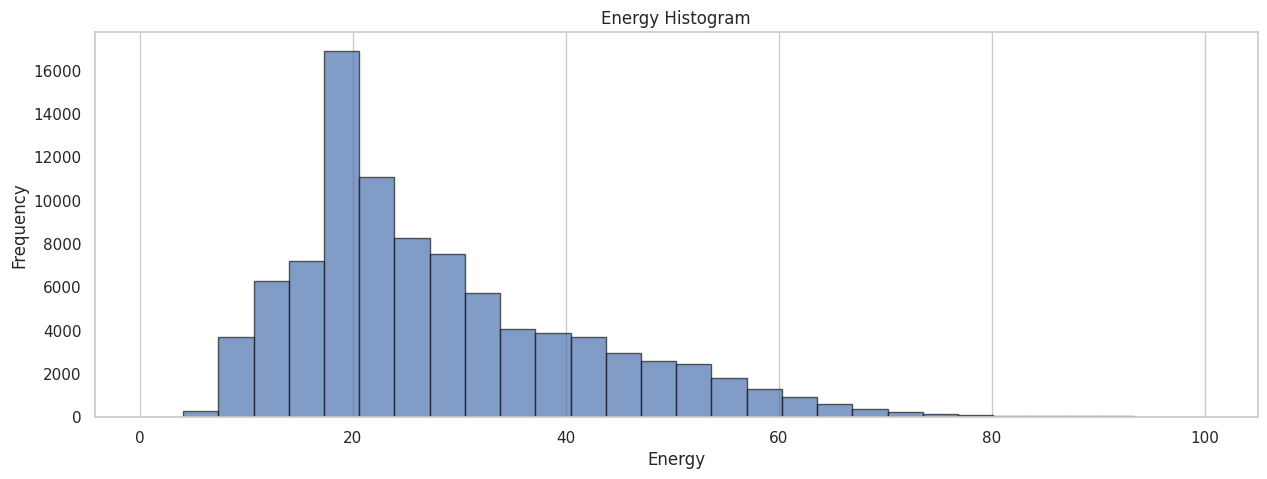

In [125]:
plt.figure(figsize=(15, 5))
plt.hist(df['energy'], bins=30, edgecolor='k', alpha=0.7)
plt.xlabel('Energy')
plt.ylabel('Frequency')
plt.title('Energy Histogram')
plt.grid(axis='y')
plt.show()

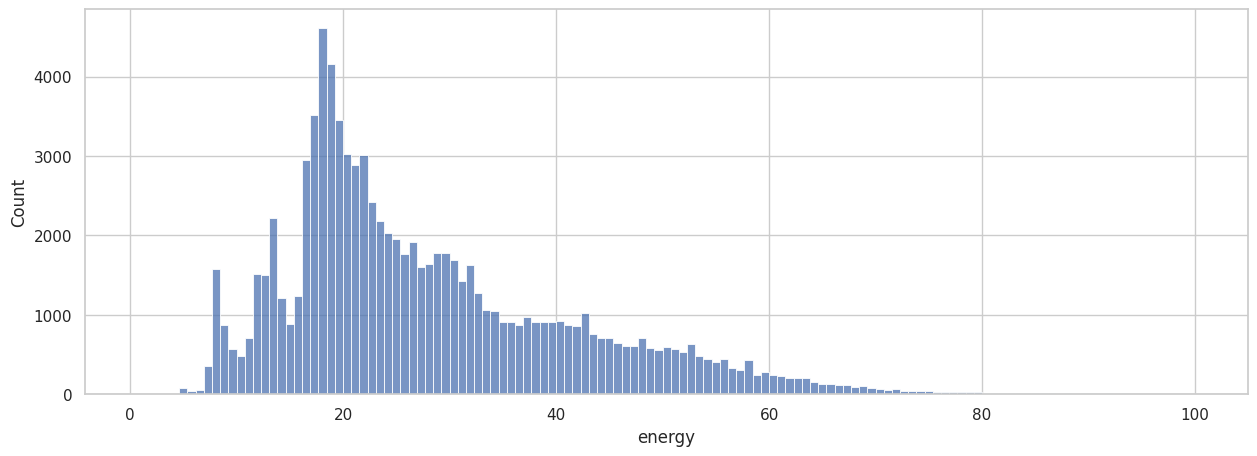

In [126]:
plt.figure(figsize=(15, 5))
sns.histplot(df['energy'])
plt.show()

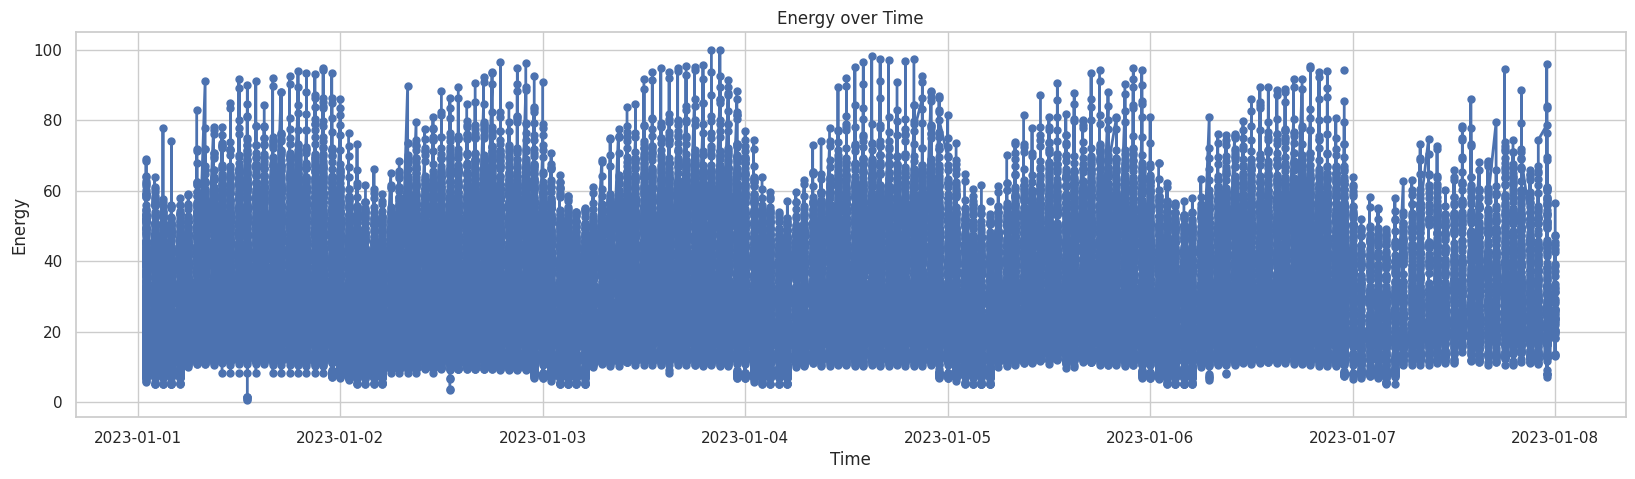

In [127]:
plt.figure(figsize=(20, 5))
plt.plot(df['time'], df['energy'], color='b', marker='o', linestyle='-', linewidth=2, markersize=5)
plt.xlabel('Time')
plt.ylabel('Energy')
plt.title('Energy over Time')
plt.grid(True)
plt.show()

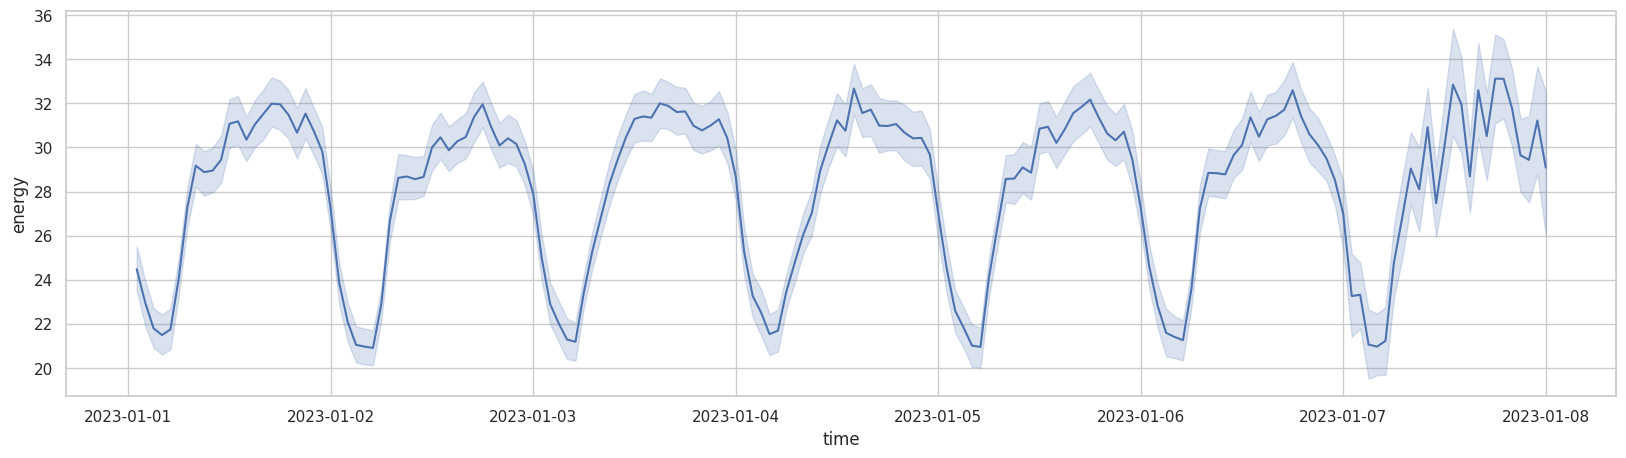

In [128]:
plt.figure(figsize=(20, 5))
sns.lineplot(data=df, x='time', y='energy')
plt.show()

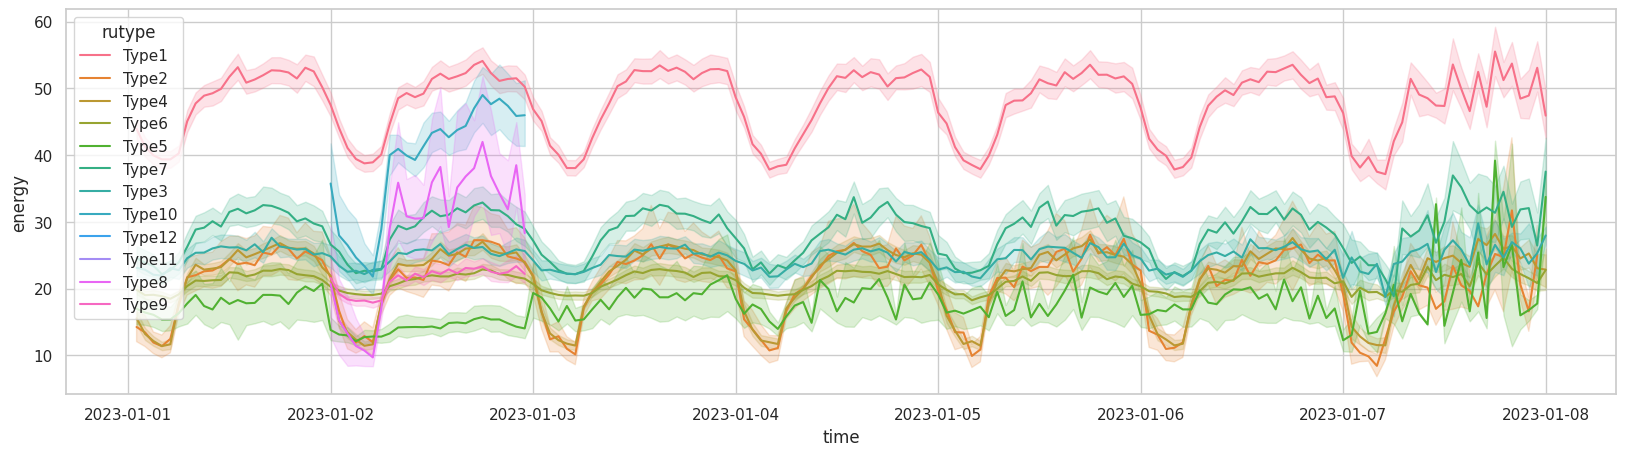

In [129]:
plt.figure(figsize=(20, 5))
sns.lineplot(data=df, x='time', y='energy', hue='rutype')
plt.show()

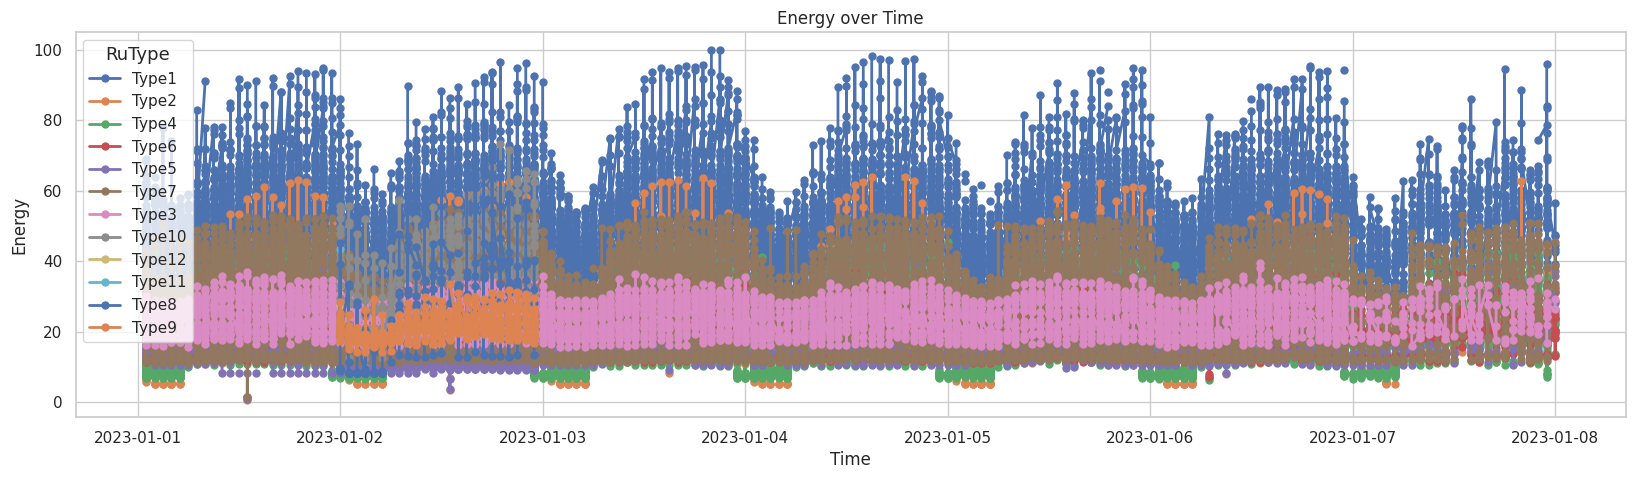

In [130]:
unique_rutypes = df['rutype'].unique()

plt.figure(figsize=(20, 5))

# Loop through each unique 'rutype' and plot a separate line for each
for rutype in unique_rutypes:
    subset_df = df[df['rutype'] == rutype]
    plt.plot(subset_df['time'], subset_df['energy'], marker='o', linestyle='-', linewidth=2, markersize=5, label=rutype)

# Setting the labels and title
plt.xlabel('Time')
plt.ylabel('Energy')
plt.title('Energy over Time')

# Adding a legend to indicate which line corresponds to which 'rutype'
plt.legend(title='RuType', title_fontsize='13', loc='upper left')

# Displaying the grid
plt.grid(True)

# Displaying the plot
plt.show()

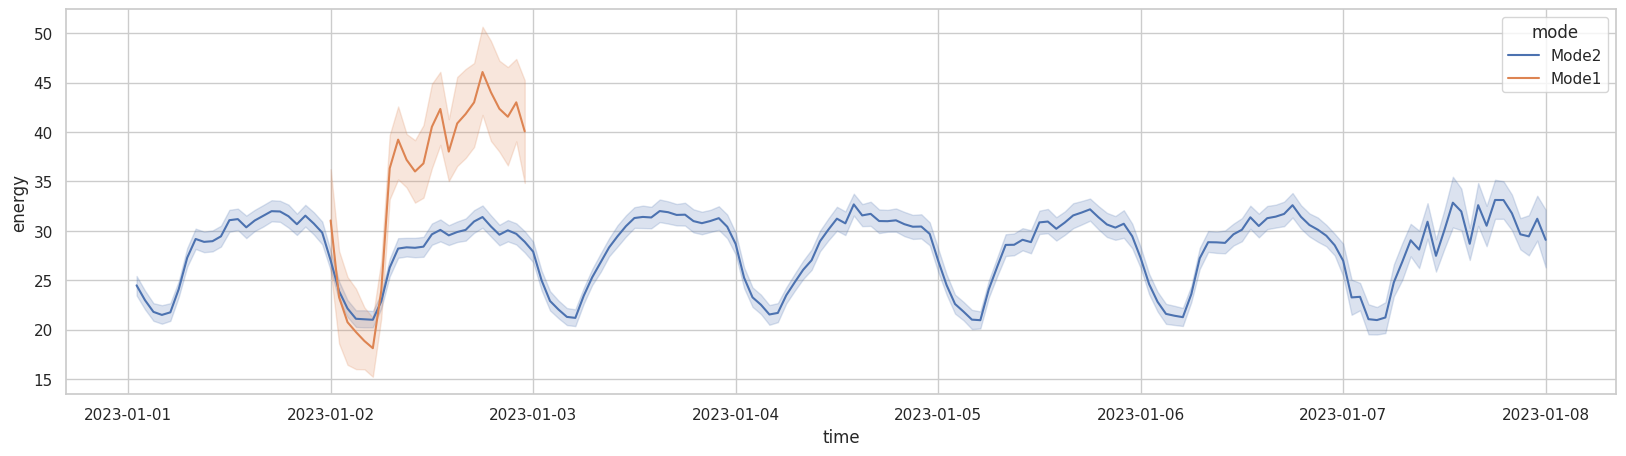

In [131]:
plt.figure(figsize=(20, 5))
sns.lineplot(data=df, x='time', y='energy', hue='mode')
plt.show()

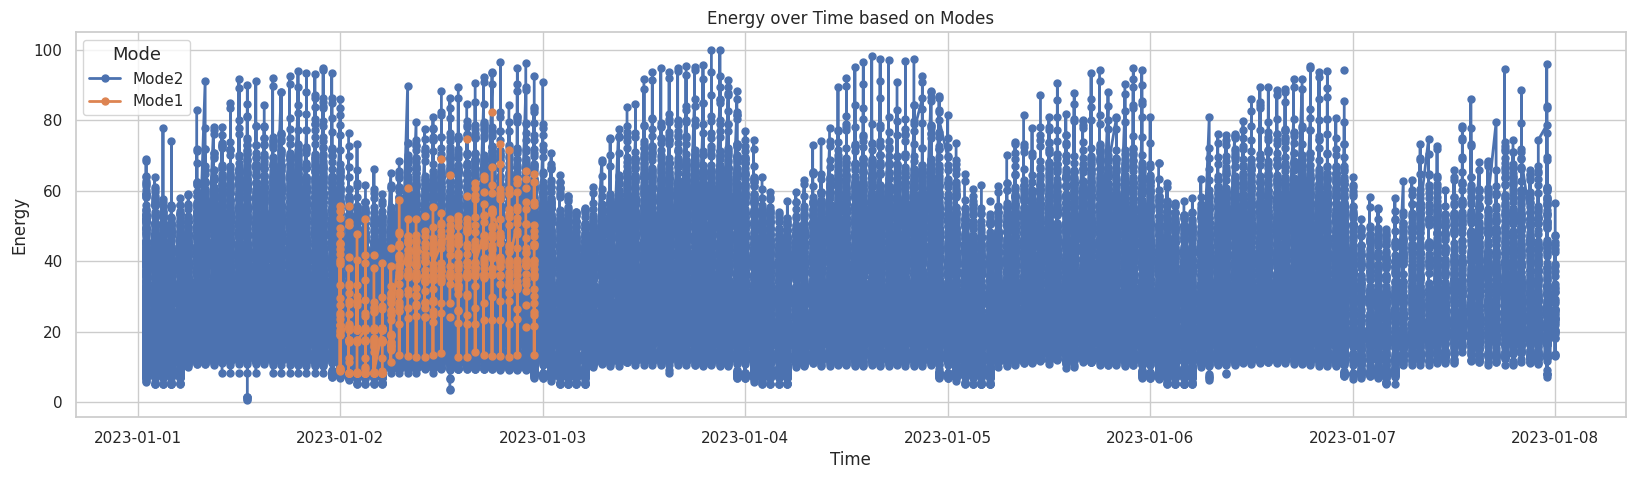

In [132]:
unique_modes = df['mode'].unique()

plt.figure(figsize=(20, 5))

# Loop through each unique 'mode' and plot a separate line for each
for mode in unique_modes:
    subset_df = df[df['mode'] == mode]
    plt.plot(subset_df['time'], subset_df['energy'], marker='o', linestyle='-', linewidth=2, markersize=5, label=mode)

# Setting the labels and title
plt.xlabel('Time')
plt.ylabel('Energy')
plt.title('Energy over Time based on Modes')

# Adding a legend to indicate which line corresponds to which 'mode'
plt.legend(title='Mode', title_fontsize='13', loc='upper left')

# Displaying the grid
plt.grid(True)

# Displaying the plot
plt.show()

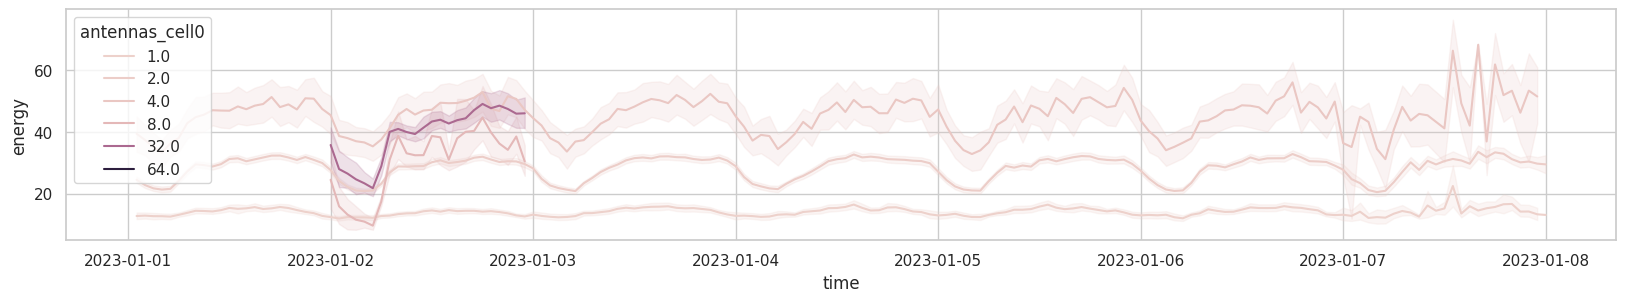

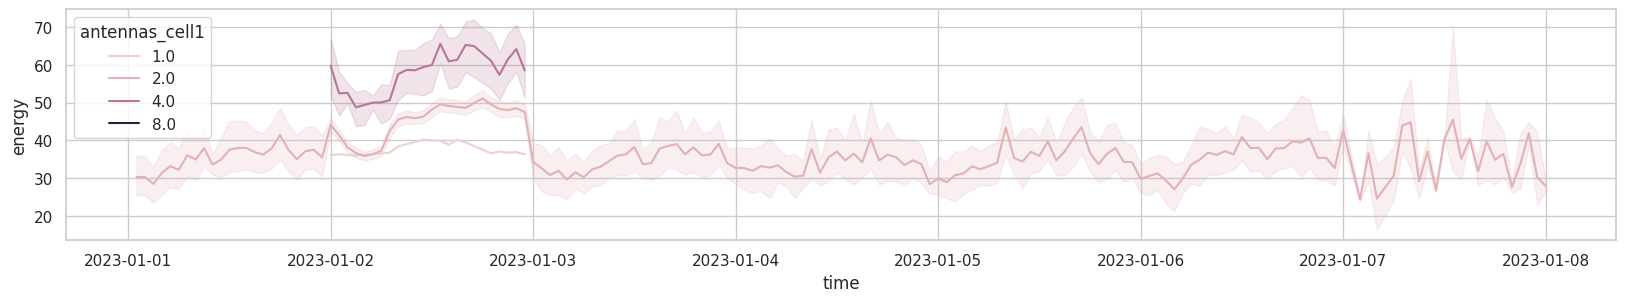

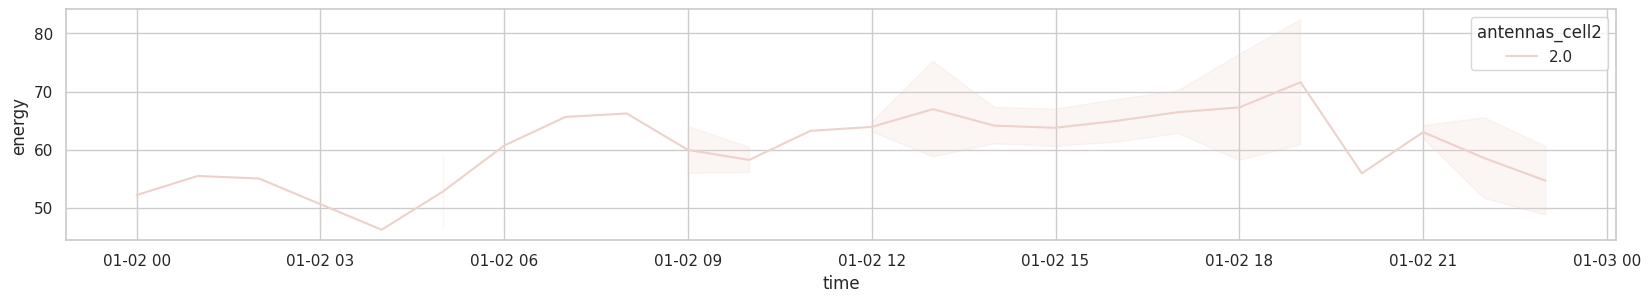

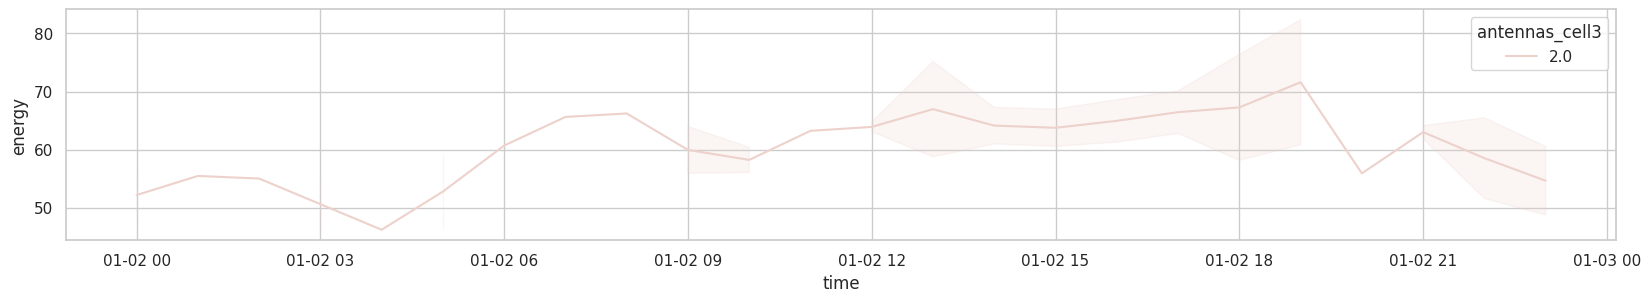

In [133]:
plt.figure(figsize=(20, 3))
sns.lineplot(data=df, x='time', y='energy', hue='antennas_cell0')
plt.show()

plt.figure(figsize=(20, 3))
sns.lineplot(data=df, x='time', y='energy', hue='antennas_cell1')
plt.show()

plt.figure(figsize=(20, 3))
sns.lineplot(data=df, x='time', y='energy', hue='antennas_cell2')
plt.show()

plt.figure(figsize=(20, 3))
sns.lineplot(data=df, x='time', y='energy', hue='antennas_cell3')
plt.show()

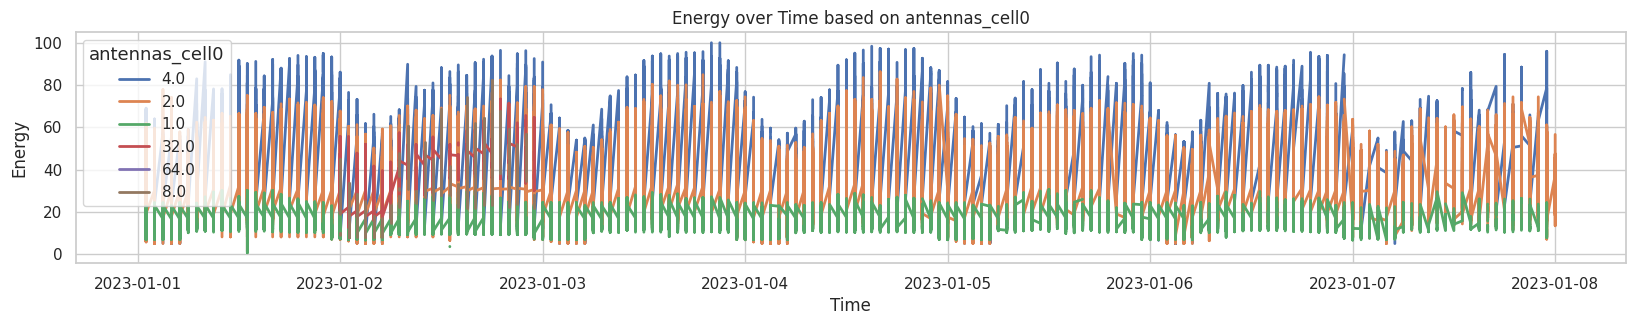

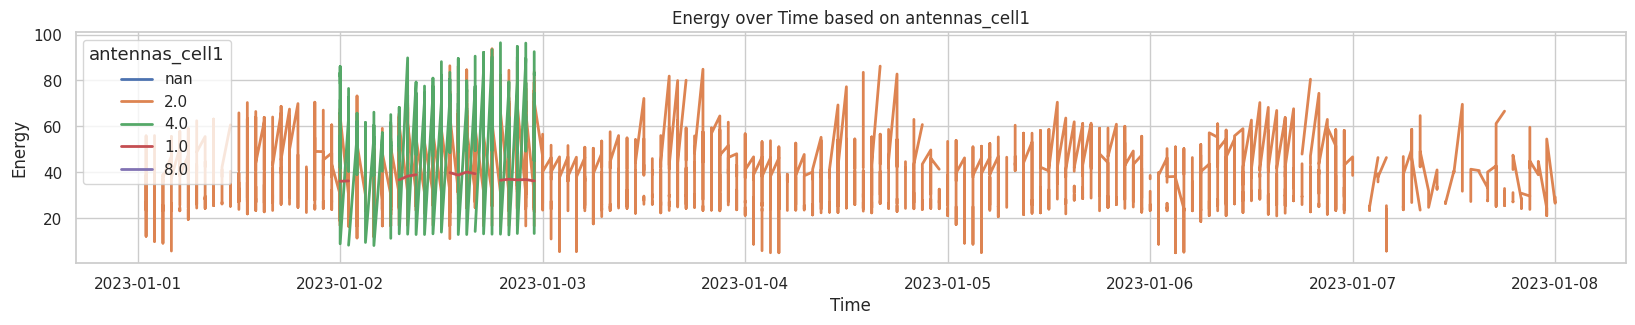

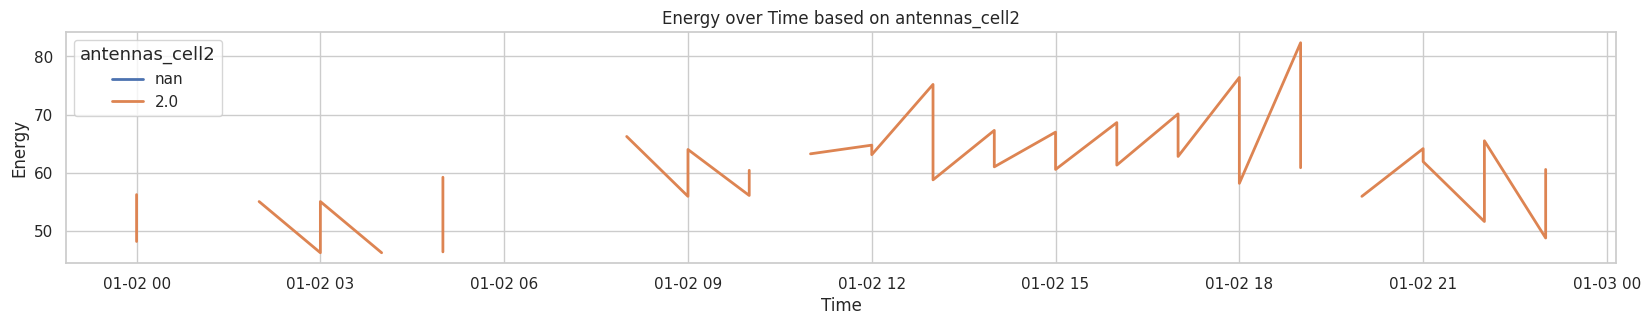

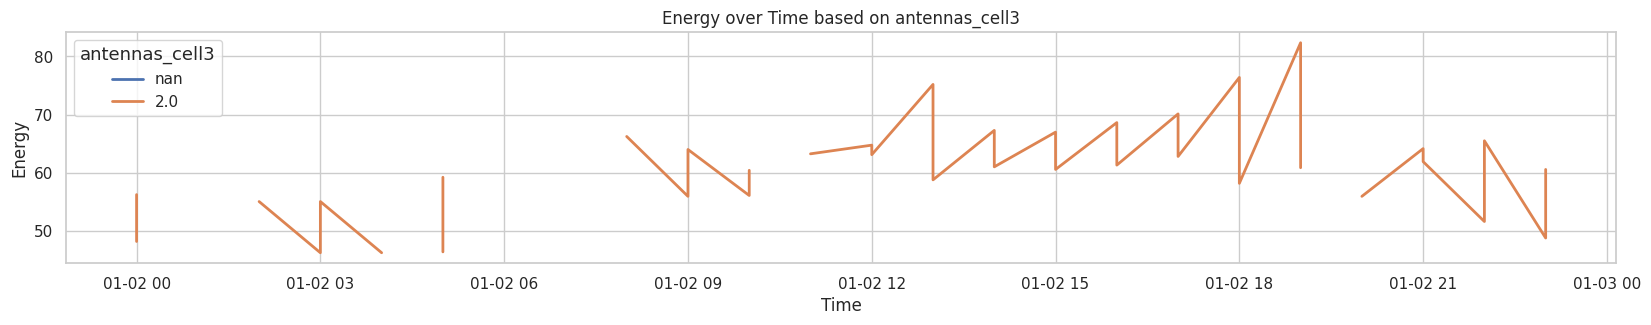

In [134]:
antenna_cols = ['antennas_cell0', 'antennas_cell1', 'antennas_cell2', 'antennas_cell3']

for antenna_col in antenna_cols:
    # Get unique values in the current antenna column
    unique_antennas = df[antenna_col].unique()

    plt.figure(figsize=(20, 3))

    for antenna in unique_antennas:
        # Create a subset of the dataframe where the current antenna column equals the current antenna value
        subset_df = df[df[antenna_col] == antenna]

        # Plot the subset data
        plt.plot(subset_df['time'], subset_df['energy'], marker='', linestyle='-', linewidth=2, label=antenna)

    # Set labels and title
    plt.xlabel('Time')
    plt.ylabel('Energy')
    plt.title(f'Energy over Time based on {antenna_col}')

    # Add a legend to indicate which line corresponds to which antenna value
    plt.legend(title=antenna_col, title_fontsize='13', loc='upper left')

    # Display the grid
    plt.grid(True)

    # Display the plot
    plt.show()

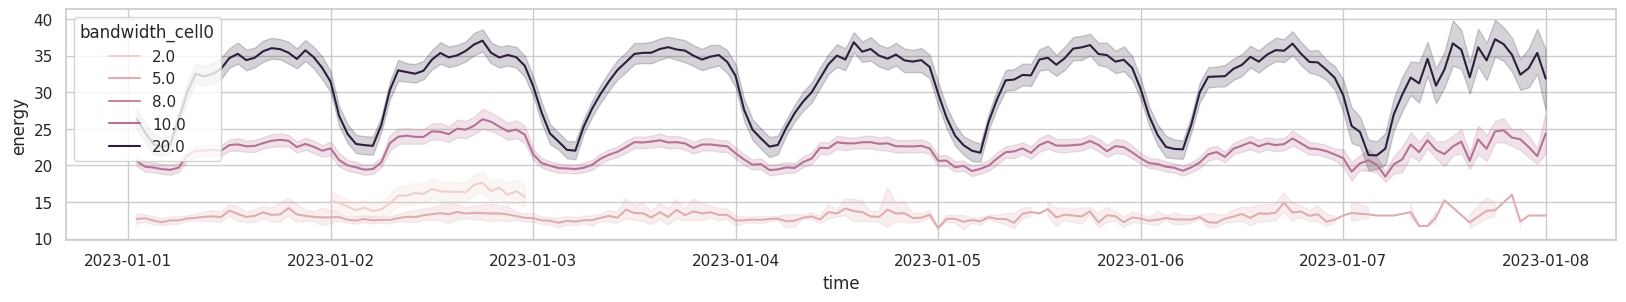

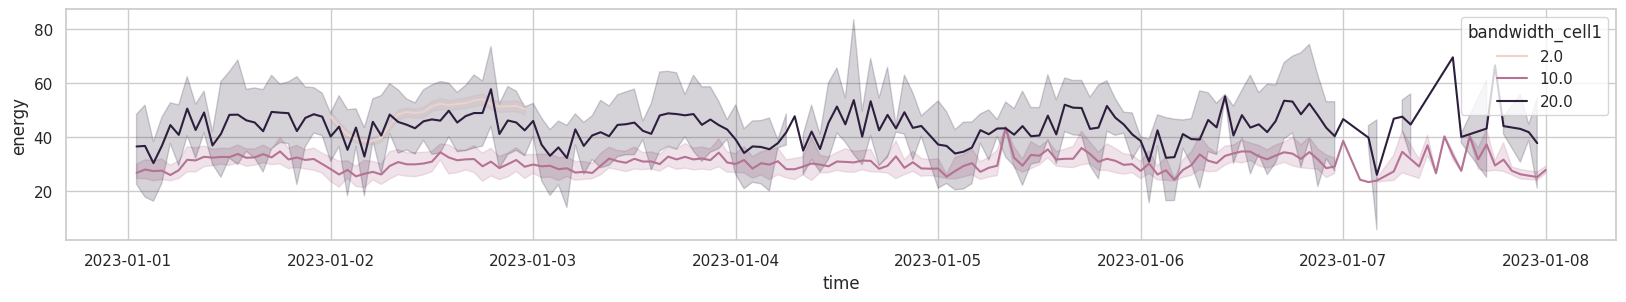

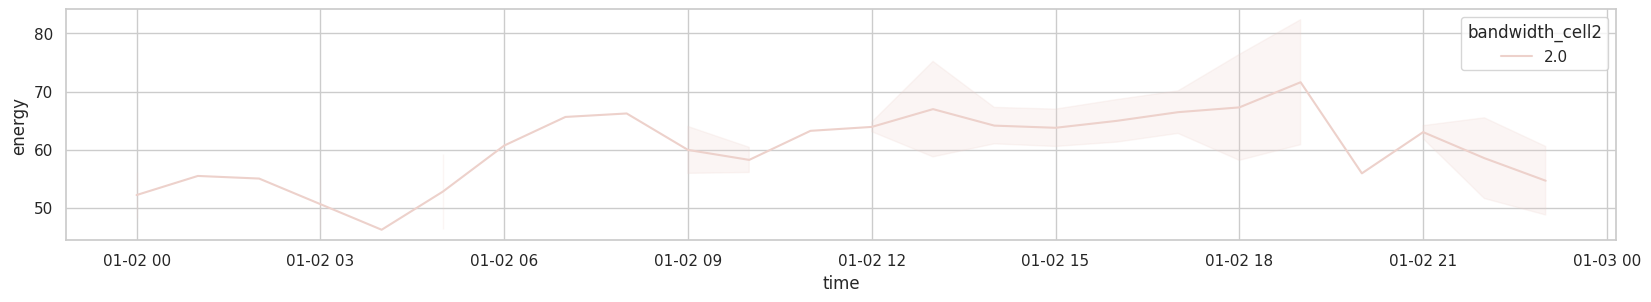

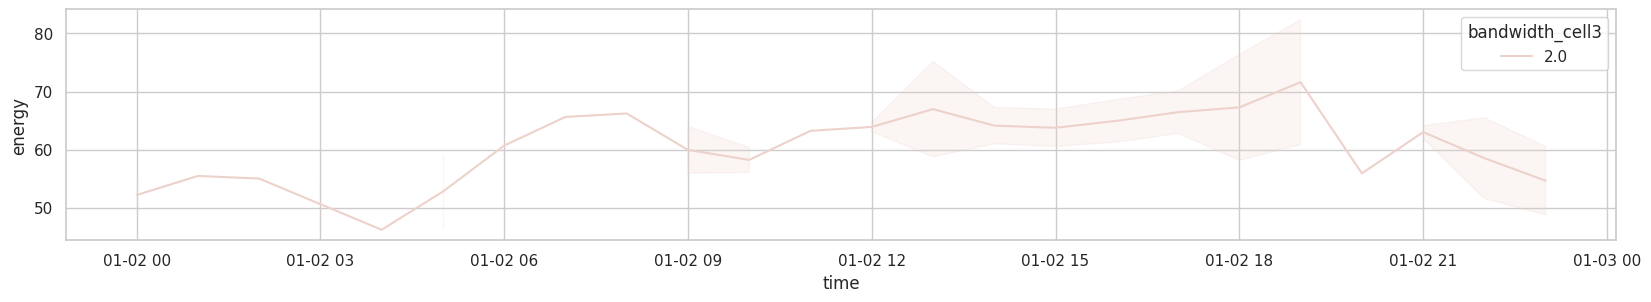

In [135]:
plt.figure(figsize=(20, 3))
sns.lineplot(data=df, x='time', y='energy', hue='bandwidth_cell0')
plt.show()

plt.figure(figsize=(20, 3))
sns.lineplot(data=df, x='time', y='energy', hue='bandwidth_cell1')
plt.show()

plt.figure(figsize=(20, 3))
sns.lineplot(data=df, x='time', y='energy', hue='bandwidth_cell2')
plt.show()

plt.figure(figsize=(20, 3))
sns.lineplot(data=df, x='time', y='energy', hue='bandwidth_cell3')
plt.show()

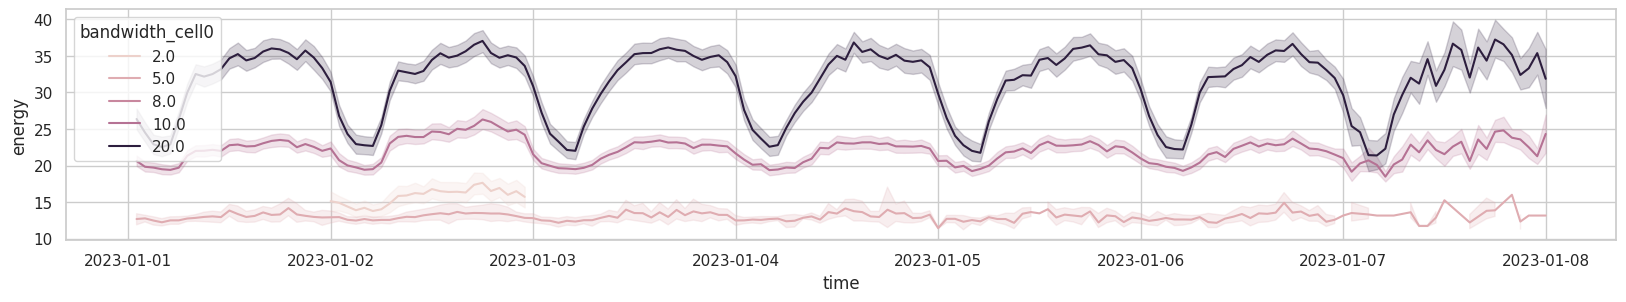

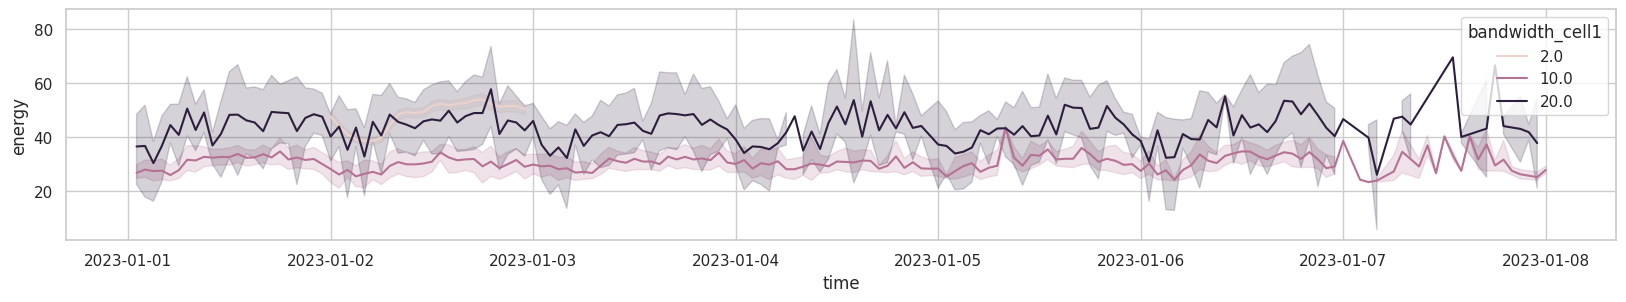

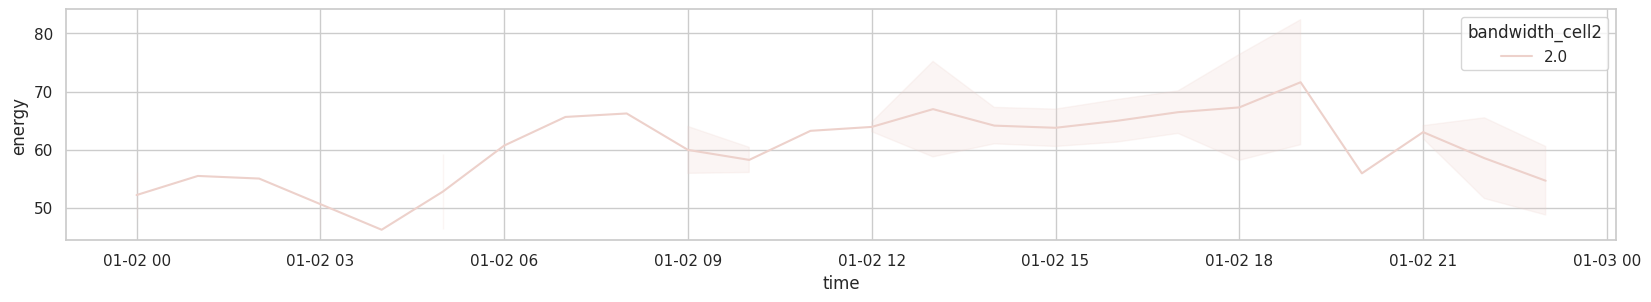

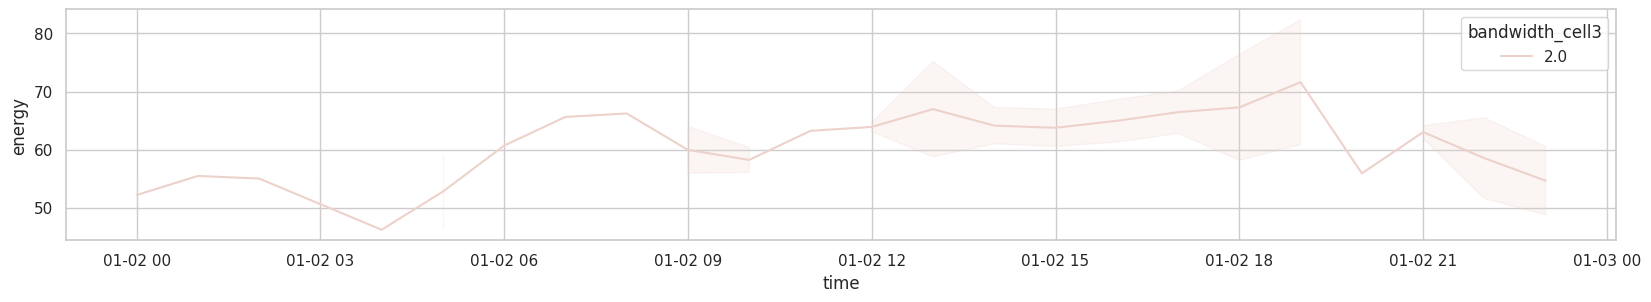

In [136]:


# List of bandwidth columns
bandwidth_cols = ['bandwidth_cell0', 'bandwidth_cell1', 'bandwidth_cell2', 'bandwidth_cell3']

for bandwidth_col in bandwidth_cols:
    plt.figure(figsize=(20, 3))
    sns.lineplot(data=df, x='time', y='energy', hue=bandwidth_col)
    plt.show()

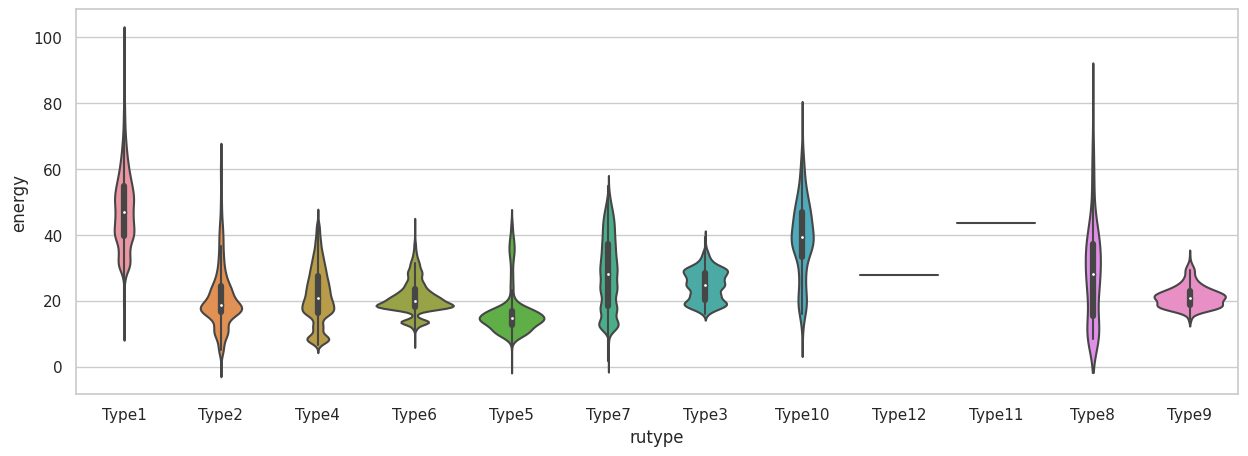

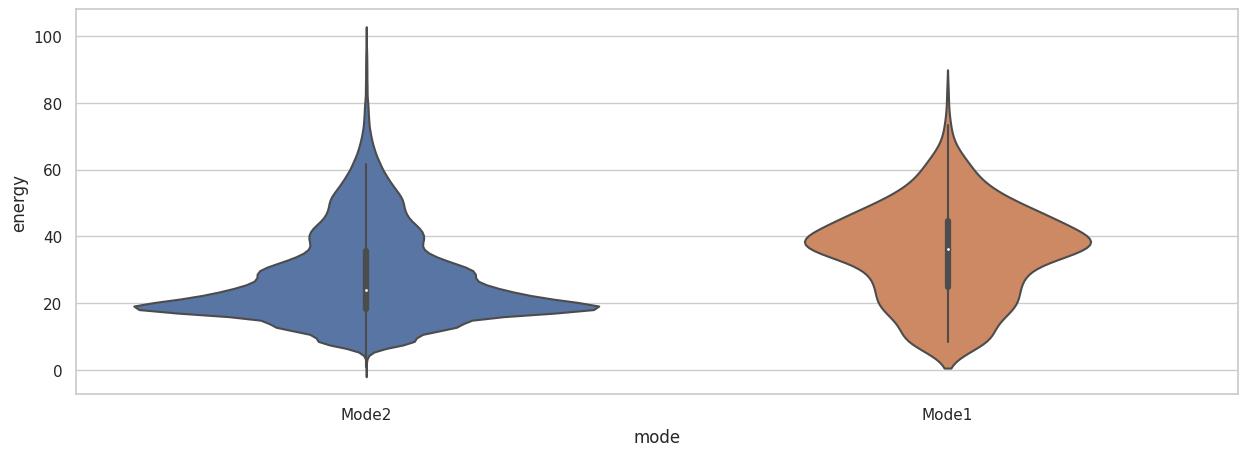

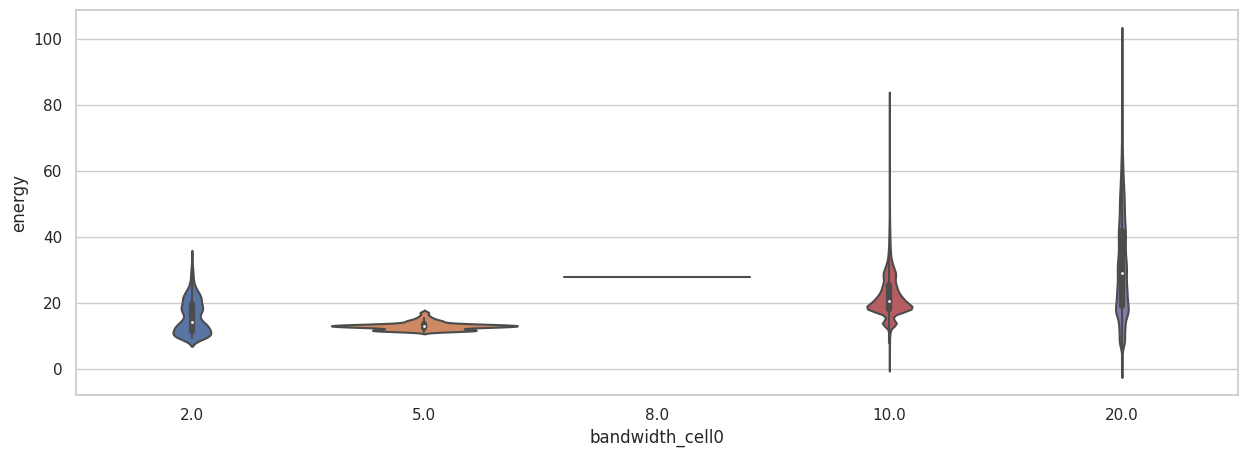

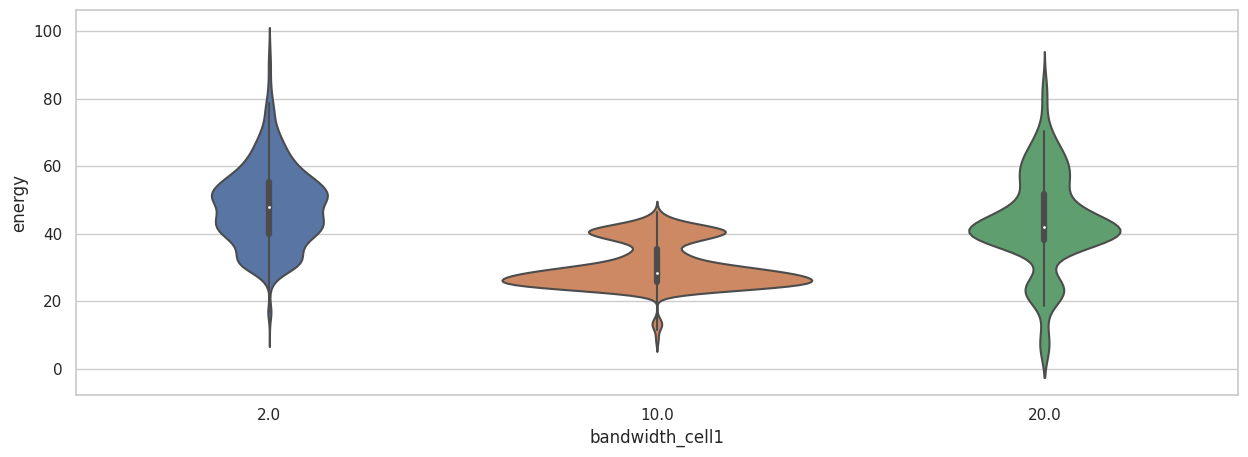

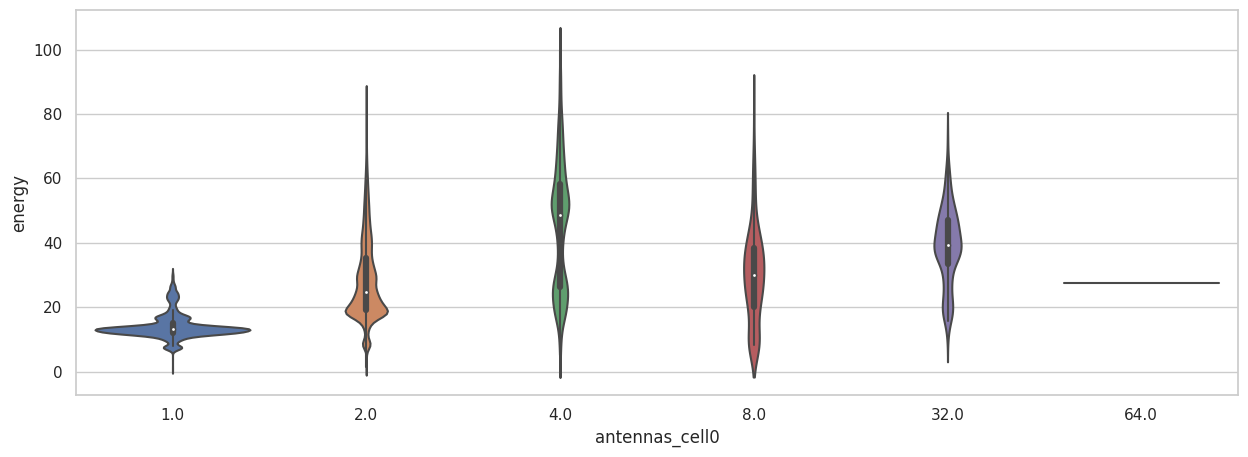

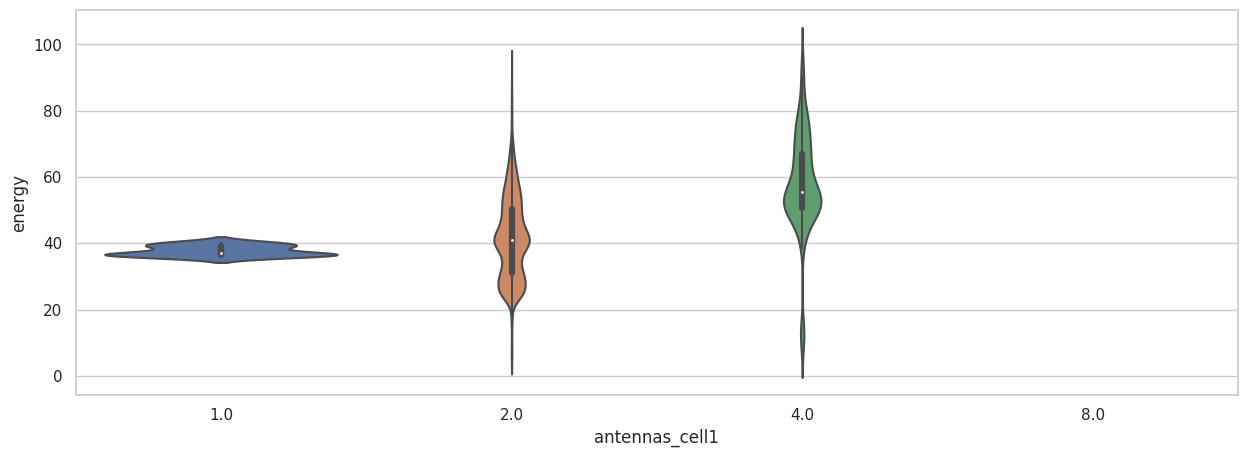

In [137]:
for fe in ['rutype', 'mode', 'bandwidth_cell0', 'bandwidth_cell1', 'antennas_cell0', 'antennas_cell1']:
    plt.figure(figsize=(15, 5))
    sns.violinplot(data=df, x=fe, y='energy')
    plt.show()

In [138]:
def plot_cat_train_test_dist(df, fe_name, hue='split'):

    # Create a figure with two subplots
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))

    # Plot the histogram plot on the first subplot
    sns.histplot(data=df[df['split'] == 'train'], ax=axes[0], x=fe_name, discrete=True)
    axes[0].set_title('Train Histogram Plot')

    # Plot the histogram plot on the second subplot
    sns.histplot(data=df[df['split'] == 'test'], ax=axes[1], x=fe_name, discrete=True)
    axes[1].set_title('Test Histogram Plot')

    # Plot the combined histogram plot on the third subplot
    sns.histplot(data=df, ax=axes[2], x=fe_name, hue=hue, discrete=True)
    axes[2].set_title('Train & Test Histogram Plot')

    plt.show()

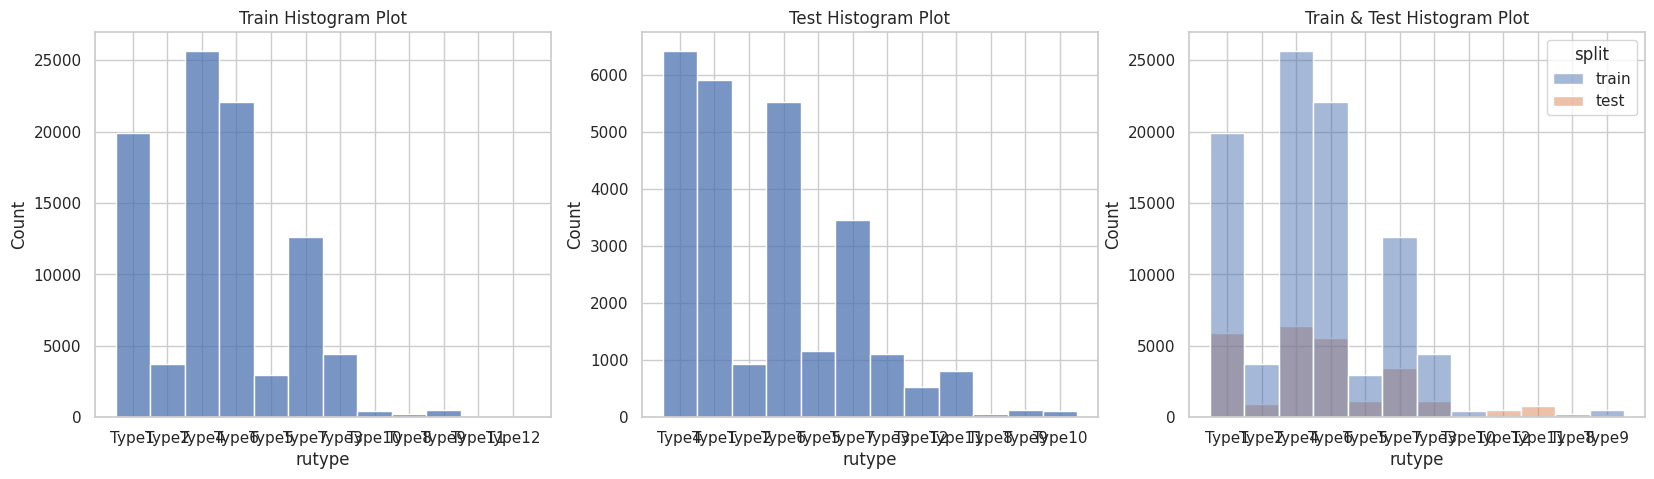

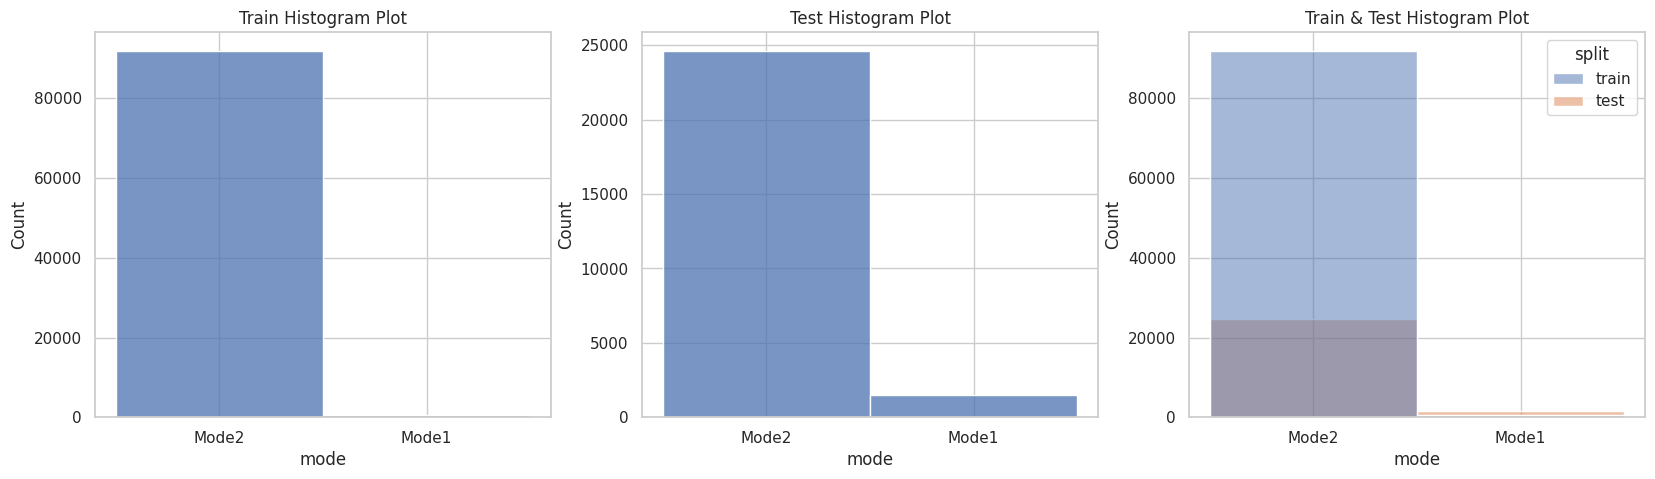

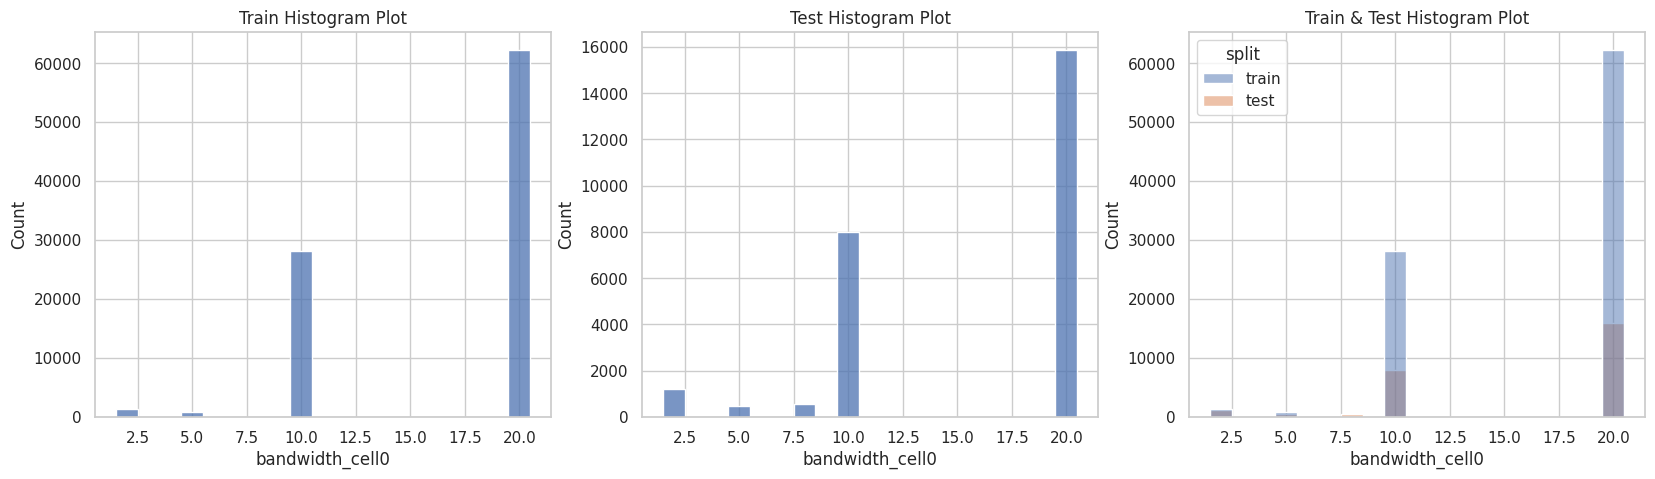

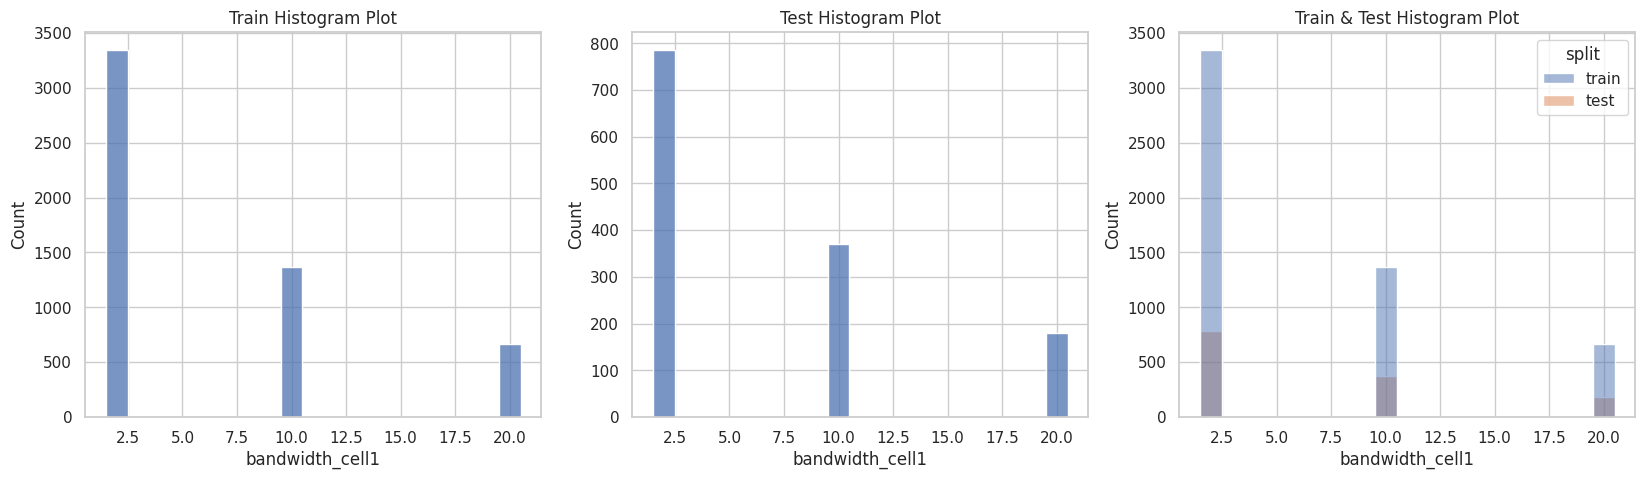

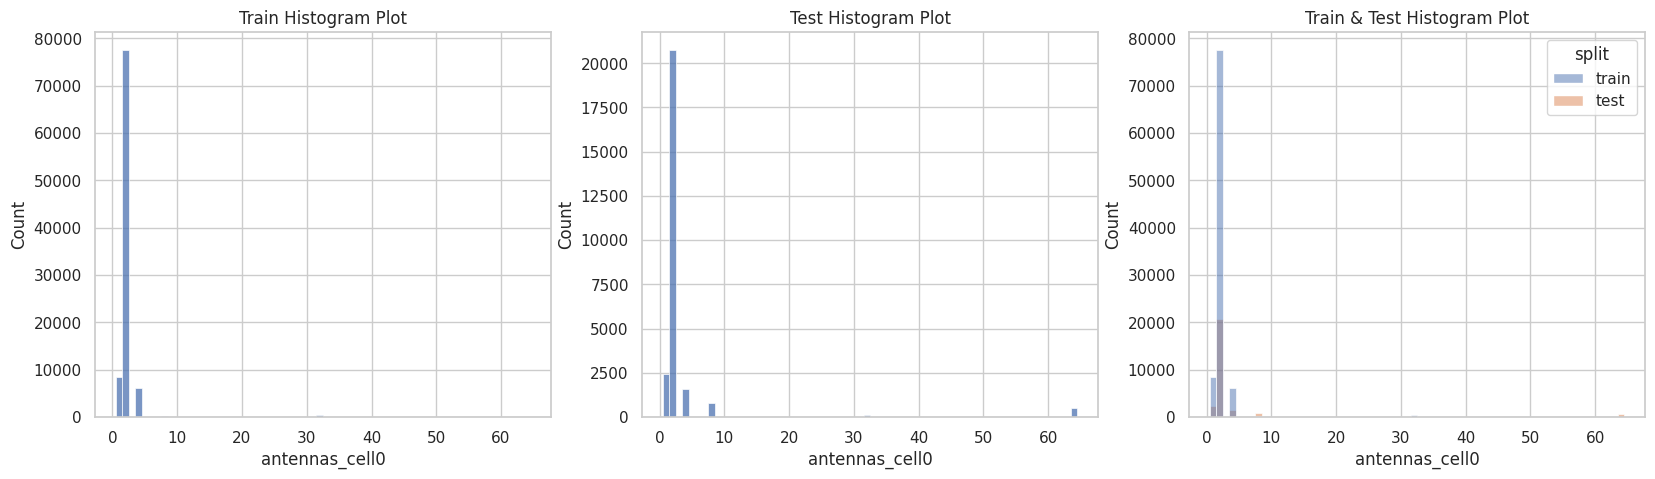

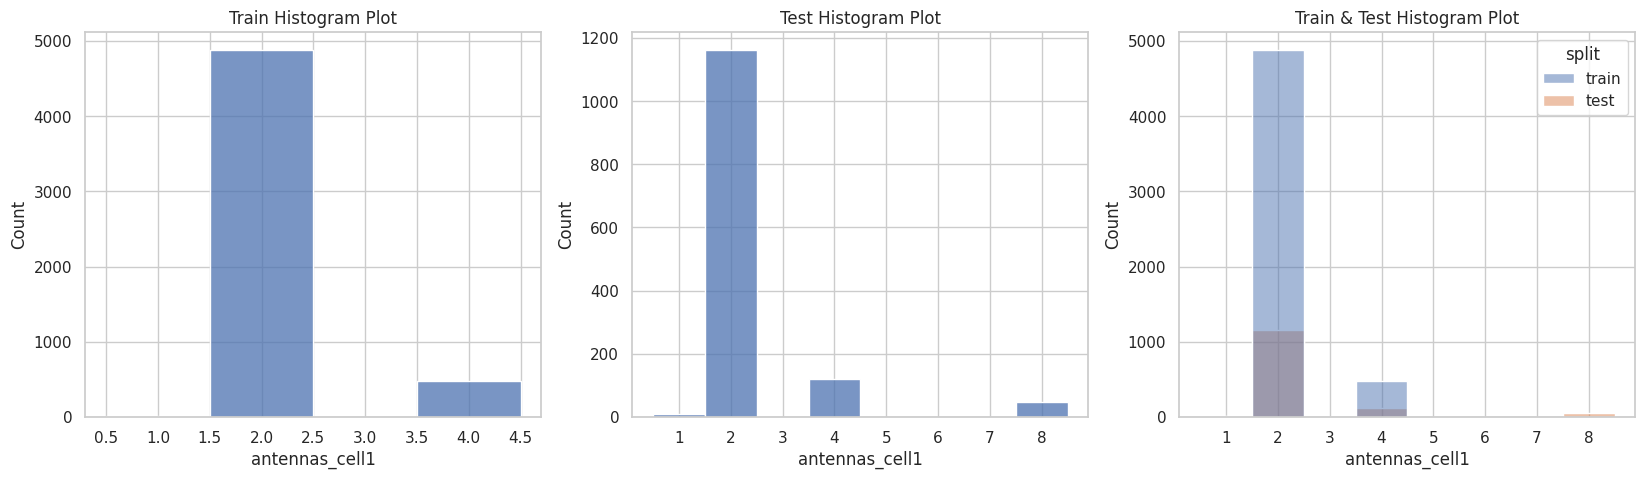

In [139]:
feature_params_list = [
    {'fe_name': 'rutype', 'hue': 'split'},
    {'fe_name': 'mode', 'hue': 'split'},
    {'fe_name': 'bandwidth_cell0', 'hue': 'split'},
    {'fe_name': 'bandwidth_cell1', 'hue': 'split'},
    {'fe_name': 'antennas_cell0', 'hue': 'split'},
    {'fe_name': 'antennas_cell1', 'hue': 'split'}
]

for params in feature_params_list:
    plot_cat_train_test_dist(df=df, **params)

In [140]:
pivot_table_result = df.pivot_table(index='split', columns='rutype', aggfunc='size', fill_value=0)
print(pivot_table_result)


rutype  Type1  Type10  Type11  Type12  Type2  Type3  Type4  Type5  Type6  \
split                                                                      
test     5908     101     815     527    939   1111   6419   1164   5521   
train   19902     403       1       1   3757   4442  25677   2974  22083   

rutype  Type7  Type8  Type9  
split                        
test     3446     58    130  
train   12641    230    518  


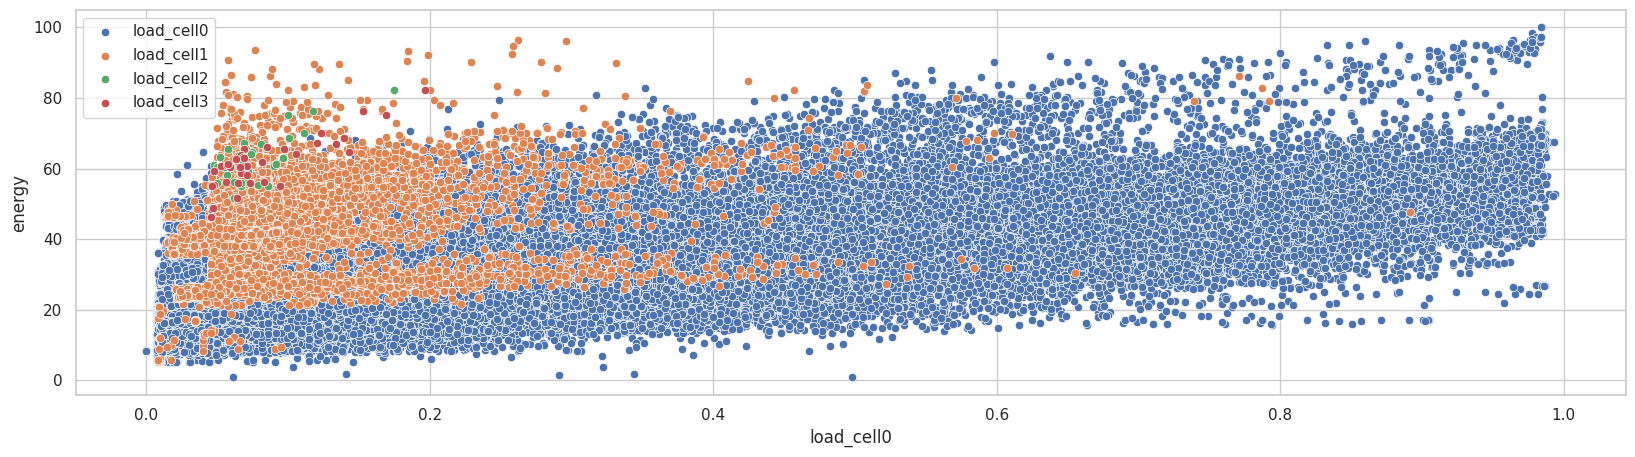

In [141]:
plt.figure(figsize=(20, 5))

cell_loads = ['load_cell0', 'load_cell1', 'load_cell2', 'load_cell3']
for load in cell_loads:
    sns.scatterplot(data=df[df['split'] == 'train'], x=load, y='energy', label=load)

plt.legend()
plt.show()


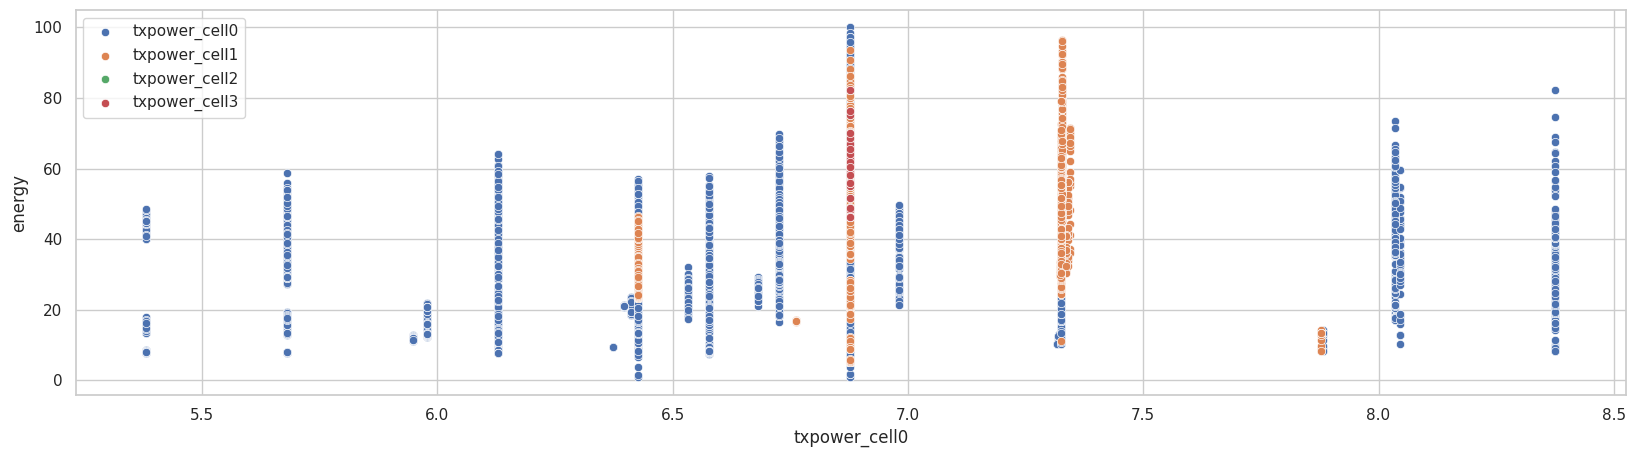

In [142]:
plt.figure(figsize=(20, 5))

txpower_cells = ['txpower_cell0', 'txpower_cell1', 'txpower_cell2', 'txpower_cell3']
for txpower in txpower_cells:
    sns.scatterplot(data=df[df['split'] == 'train'], x=txpower, y='energy', label=txpower)

plt.legend()
plt.show()


## Modeling

In [143]:
train_data = df[df['split'] =='train']
test_data = df[df['split'] =='test']

train_data.shape, test_data.shape

((92629, 50), (26139, 50))

In [144]:
def feature_enginning(train_df, valid_df, test_df):

    train_df['hour'] = train_df['time'].dt.hour
    valid_df['hour'] = valid_df['time'].dt.hour
    test_df['hour'] = test_df['time'].dt.hour

    # target_encoder = TargetEncoder(min_samples_leaf=1)
    # train_df[['te_rutype', 'te_mode', 'te_hour', 'te_bs']] = target_encoder.fit_transform(X=train_df[['rutype', 'mode', 'hour', 'bs']], y=train_df['energy'])
    # valid_df[['te_rutype', 'te_mode', 'te_hour', 'te_bs']] = target_encoder.transform(X=valid_df[['rutype', 'mode', 'hour', 'bs']])
    # test_df[['te_rutype', 'te_mode', 'te_hour', 'te_bs']] = target_encoder.transform(X=test_df[['rutype', 'mode', 'hour', 'bs']])

    train_df['split'] = 'train'
    valid_df['split'] = 'valid'
    test_df['split'] = 'test'

    df = pd.concat([train_df, valid_df, test_df])
    df['bs_en'] = df['bs'].apply(lambda x: int(x.strip('B_')))

    # df['rutype'] = df['rutype'].apply(lambda x: int(x.strip('Type')))
    # df['mode'] = df['mode'].apply(lambda x: int(x.strip('Mode')))

    df = pd.get_dummies(df, columns=['rutype',  'mode', 'hour'])

    df.sort_values(['time', 'bs'], inplace=True)
    # for fe in ['antennas_cell0', 'antennas_cell1', 'antennas_cell2', 'antennas_cell3', 'load_cell0', 'load_cell1',
    #    'load_cell2', 'load_cell3', 'txpower_cell0', 'txpower_cell1', 'txpower_cell2', 'txpower_cell3']:
    #     for r in [3, 5, 8, 10, 15]:
    #         df[f'r{r}_mean_{fe}'] = df.groupby(['bs'])[f'{fe}'].transform(lambda x: x.rolling(r, min_periods=1).mean())
    #         df[f'r{r}_std_{fe}'] = df.groupby(['bs'])[f'{fe}'].transform(lambda x: x.rolling(r, min_periods=1).std())
    #         df[f'r{r}_skew_{fe}'] = df.groupby(['bs'])[f'{fe}'].transform(lambda x: x.rolling(r, min_periods=1).skew())
    #         df[f'r{r}_max_{fe}'] = df.groupby(['bs'])[f'{fe}'].transform(lambda x: x.rolling(r, min_periods=1).max())

    # Target rolling
    # for fe in ['energy']:
    #     for r in [3, 5, 8, 10, 15]:
    #         df[f'r{r}_mean_{fe}'] = df.groupby(['bs'])[f'{fe}'].transform(lambda x: x.rolling(r, min_periods=1).mean().shift(1))
    #         df[f'r{r}_std_{fe}'] = df.groupby(['bs'])[f'{fe}'].transform(lambda x: x.rolling(r, min_periods=1).std().shift(1))
    #         df[f'r{r}_skew_{fe}'] = df.groupby(['bs'])[f'{fe}'].transform(lambda x: x.rolling(r, min_periods=1).skew().shift(1))
    #         df[f'r{r}_max_{fe}'] = df.groupby(['bs'])[f'{fe}'].transform(lambda x: x.rolling(r, min_periods=1).max().shift(1))


    train_df = df[df['split'] =='train']
    valid_df = df[df['split'] =='valid']
    test_df = df[df['split'] =='test']

    return train_df, valid_df, test_df

In [145]:
target_col = 'energy'
drop_cols = ['time', 'bs', 'split', target_col]

In [146]:
kf = model_selection.KFold(n_splits=5)
kf = kf.split(X=train_data)

oof_valid_preds = np.zeros(train_data.shape[0], )
test_preds_list = []

for i, (train_idx, valid_idx) in enumerate(kf):

    train_df = train_data.iloc[train_idx]
    valid_df = train_data.iloc[valid_idx]
    test_df = test_data.copy()

    train_df, valid_df, test_df = feature_enginning(train_df=train_df, valid_df=valid_df, test_df=test_df)
    train_cols = [col for col in train_df.columns if col not in drop_cols]

    X_train, y_train = train_df[train_cols], train_df[target_col]
    X_valid, y_valid = valid_df[train_cols], valid_df[target_col]
    X_test = test_df[train_cols]

    params = {
        'loss_function': 'MAE',
        'iterations': 10000,
        'depth': 6,
        'learning_rate': 0.1,
        'thread_count': -1,
        'verbose': 100,
        'task_type': 'CPU'
    }

    model = CatBoostRegressor(**params)

    train_pool = Pool(data=X_train, label=y_train)
    val_pool = Pool(data=X_valid, label=y_valid)

    model.fit(train_pool, eval_set=val_pool, early_stopping_rounds=100)

    valid_preds = model.predict(X_valid)
    test_preds = model.predict(X_test)

    val_score = metrics.mean_absolute_error(y_valid, valid_preds)
    oof_valid_preds[valid_idx] = valid_preds
    test_preds_list.append(test_preds)

    print("=*"*50)
    print(f"Fold : {i}")
    print(f"Valid score : ", val_score)

oof_score = metrics.mean_absolute_error(train_data[target_col], oof_valid_preds)
print("_-*"*50)
print(f"OOF score : ", oof_score)

0:	learn: 9.7747776	test: 9.7771199	best: 9.7771199 (0)	total: 76.7ms	remaining: 12m 47s
100:	learn: 2.5634457	test: 2.6699008	best: 2.6699008 (100)	total: 2.02s	remaining: 3m 18s
200:	learn: 2.2725482	test: 2.3842562	best: 2.3842562 (200)	total: 3.93s	remaining: 3m 11s
300:	learn: 2.1144635	test: 2.2325215	best: 2.2325215 (300)	total: 5.82s	remaining: 3m 7s
400:	learn: 2.0014012	test: 2.1152867	best: 2.1152867 (400)	total: 8.16s	remaining: 3m 15s
500:	learn: 1.9009068	test: 2.0107789	best: 2.0107789 (500)	total: 11.1s	remaining: 3m 30s
600:	learn: 1.8283976	test: 1.9404044	best: 1.9404044 (600)	total: 13s	remaining: 3m 23s
700:	learn: 1.7739921	test: 1.8912590	best: 1.8912590 (700)	total: 14.9s	remaining: 3m 17s
800:	learn: 1.7184153	test: 1.8352908	best: 1.8352908 (800)	total: 16.9s	remaining: 3m 13s
900:	learn: 1.6653642	test: 1.7852963	best: 1.7852963 (900)	total: 18.8s	remaining: 3m 10s
1000:	learn: 1.6266637	test: 1.7502704	best: 1.7502704 (1000)	total: 21.7s	remaining: 3m 14s
11

In [147]:
test_preds_list

[array([14.91202605, 46.65454389, 18.50156437, ..., 17.74299146,
        20.64737145, 36.76796258]),
 array([15.04510371, 47.10127561, 18.05357602, ..., 17.42301779,
        20.77431959, 36.93309845]),
 array([14.62201322, 46.09886857, 19.62372125, ..., 17.97643794,
        20.44504324, 36.1126272 ]),
 array([14.64974841, 46.77140543, 18.80681087, ..., 17.84383893,
        20.87141496, 36.49241807]),
 array([14.76332816, 47.15521962, 17.48186845, ..., 17.7643437 ,
        20.88417142, 37.31129607])]

In [148]:
test_preds_mean = np.mean(test_preds_list, axis=0)

In [149]:
test_preds_mean

array([14.79844391, 46.75626262, 18.49350819, ..., 17.75012596,
       20.72446413, 36.72348047])

In [150]:
test_preds_mean.shape

(26139,)

In [151]:
test_data.shape

(26139, 50)

In [152]:
test_data['Energy'] = test_preds_mean

<Axes: >

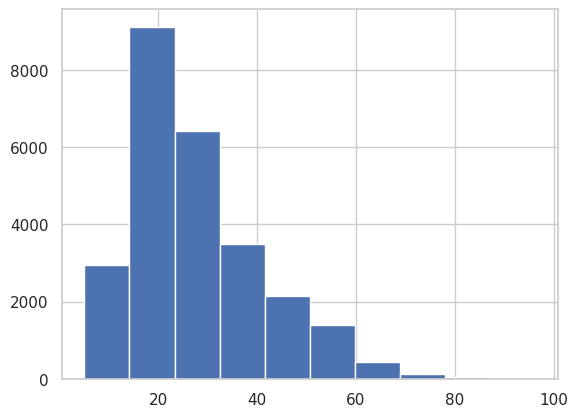

In [153]:
test_data['Energy'].hist()

In [154]:
ss_df.head()

ID  Energy
0  2023-01-01 06:00:00_B_0       0
1  2023-01-01 11:00:00_B_0       0
2  2023-01-01 12:00:00_B_0       0
3  2023-01-01 13:00:00_B_0       0
4  2023-01-01 23:00:00_B_0       0

In [155]:
test_data['ID'] = test_data['time'].astype('str') + '_' + test_data['bs']

In [156]:
test_data[['ID', 'Energy']]

ID     Energy
3       2023-01-01 01:00:00_B_100  14.798444
8       2023-01-01 01:00:00_B_105  46.756263
10      2023-01-01 01:00:00_B_107  18.493508
15      2023-01-01 01:00:00_B_111  33.979004
18      2023-01-01 01:00:00_B_114  23.262518
...                           ...        ...
118757  2023-01-08 00:00:00_B_786  24.489103
118761  2023-01-08 00:00:00_B_790  20.355931
118762  2023-01-08 00:00:00_B_791  17.750126
118763  2023-01-08 00:00:00_B_792  20.724464
118765  2023-01-08 00:00:00_B_794  36.723480

[26139 rows x 2 columns]

In [157]:
ss_df = ss_df[['ID']]
ss_df = ss_df.merge(test_data[['ID', 'Energy']], on='ID', how='left')

In [158]:
ss_df.head()

ID     Energy
0  2023-01-01 06:00:00_B_0  57.614471
1  2023-01-01 11:00:00_B_0  73.268708
2  2023-01-01 12:00:00_B_0  69.784262
3  2023-01-01 13:00:00_B_0  71.280043
4  2023-01-01 23:00:00_B_0  80.130116

In [159]:
ss_df.to_csv("base_model_submission.csv", index=False)